In [1]:
# VERSION SET UP
# need to set some versions
import sys 

# For Google Colab:
# Mounting drive to access datafile
# from google.colab import drive
# drive.mount('/content/drive')

# # for Google Workbook:
# !{sys.executable} -m pip install --user pandas==1.1.5
# !{sys.executable} -m pip install --user tensorflow==1.13.1 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
# !{sys.executable} -m pip install --user numpy==1.19.5  # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
# !{sys.executable} -m pip install --user hmmlearn

# for other environments:
# !{sys.executable} -m pip install pandas==1.1.5
# !{sys.executable} -m pip install tensorflow==1.13.1 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
# !{sys.executable} -m pip install numpy==1.19.5  # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
# !{sys.executable} -m pip install hmmlearn

# may have to restart kernel after running these to get access to them

In [2]:
#Importing/installing modules
from __future__ import absolute_import, division, print_function

import collections
import hashlib
import numbers
import itertools
import functools
import inspect
import pickle

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import shutil

import tensorflow as tf
from tensorflow.contrib.rnn import PhasedLSTMCell, MultiRNNCell, BasicRNNCell
from tensorflow.python.ops import rnn_cell, rnn
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op, dtypes, ops, tensor_shape, tensor_util   
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import * 
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training import checkpointable
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import tf_export

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from hmmlearn import hmm

# Model Code
from timegan import timegan, discriminative_score_metrics,  predictive_score_metrics
from assm import attentive_state_space_model

# Evaluation
from metrics import PCA_Analysis, tSNE_Analysis

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
# version checks
# Python version
# Python version - should be 3.6 or could have issues
print('Python:',sys.version_info, '\n')

pd_check = pd.__version__=='1.1.5'
np_check = np.__version__=='1.19.5'
tf_check = tf.__version__=='1.13.1'
print('Pandas version correct', pd_check)
print('Numpy version correct', np_check)
print('TensorFlow version correct', tf_check)
if(pd_check == True and np_check == True and tf_check == True):
    print("\nVersions all correct")
else:
    print("""
    A key version of these libraries is set to the wrong version.
    Run the appropriate VERSION SET UP settings above and then restart kernel.
            """)



Python: sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0) 

Pandas version correct True
Numpy version correct True
TensorFlow version correct True

Versions all correct


In [4]:
# pull up data for EDA
# heal_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv")
# ownr_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_dog_owner_v1.1.csv")
# cncr_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_cancer_condition_v1.1.csv")

# if in Google Colab:
heal_df = pd.read_csv("/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv")
ownr_df = pd.read_csv("/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_dog_owner_v1.1.csv")
cncr_df = pd.read_csv("/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_cancer_condition_v1.1.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv'

In [ ]:
# MINOR EDA
print(len(heal_df))
print(list(heal_df.columns))
heal_df.head(10)

77576
['dog_id', 'hs_condition', 'hs_condition_cause_other_description', 'hs_condition_is_congenital', 'hs_condition_other_description', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year', 'hs_eye_condition_cause', 'hs_follow_up_ongoing', 'hs_neurological_condition_vestibular_disease_type', 'hs_required_surgery_or_hospitalization']


,dog_id,hs_condition,hs_condition_cause_other_description,hs_condition_is_congenital,hs_condition_other_description,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_eye_condition_cause,hs_follow_up_ongoing,hs_neurological_condition_vestibular_disease_type,hs_required_surgery_or_hospitalization
0,68063,423.0,NaN,False,NaN,4,3.0,2016.0,NaN,True,NaN,4.0
1,68063,426.0,NaN,False,NaN,4,3.0,2016.0,NaN,True,NaN,4.0
2,68063,712.0,NaN,False,NaN,7,3.0,2016.0,NaN,False,NaN,4.0
3,68063,714.0,NaN,False,NaN,7,8.0,2016.0,NaN,True,NaN,4.0
4,68063,1617.0,NaN,False,NaN,16,2.0,2017.0,NaN,True,NaN,4.0
5,68063,1817.0,NaN,False,NaN,18,8.0,2019.0,NaN,True,NaN,4.0
6,54147,1215.0,NaN,False,NaN,12,3.0,2020.0,NaN,True,NaN,4.0
7,54147,1803.0,NaN,False,NaN,18,6.0,2018.0,NaN,False,NaN,4.0
8,43693,305.0,NaN,False,NaN,3,3.0,2018.0,NaN,False,NaN,4.0
9,43693,307.0,NaN,False,NaN,3,1.0,2020.0,NaN,True,NaN,4.0


In [ ]:
# need to know how many records per dog
# going to handle each entry as a separate visit for now, 
# but it looks like it is an entry per disease, so should massage later
# When come back to this: assume that if same month and same year, 
# but different diseases, it was during the same visit
heal_df.groupby('dog_id').count()

,hs_condition,hs_condition_cause_other_description,hs_condition_is_congenital,hs_condition_other_description,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_eye_condition_cause,hs_follow_up_ongoing,hs_neurological_condition_vestibular_disease_type,hs_required_surgery_or_hospitalization
dog_id,,,,,,,,,,,
3,3,0,3,0,3,3,3,0,3,0,3
6,1,0,1,0,1,1,1,0,1,0,1
9,5,0,5,2,5,5,5,0,5,0,5
11,3,0,3,0,3,3,3,1,3,0,3
13,1,0,1,0,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
92568,7,0,7,4,7,7,7,0,7,0,7
92582,4,0,4,0,4,4,4,0,4,0,4
92584,3,0,3,0,3,3,3,0,3,0,3


In [ ]:
seq_length = 4
# reduce to just dogs with 4+ health records
# then look at the most common conditions & most common surgical/hospitalization scenarios
sm_hl_df = heal_df[['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
# sm_hl_df.groupby('hs_condition_type').count()
# reduce to only dogs with seq_lenth+ of records
segmin_df = sm_hl_df[sm_hl_df.groupby('dog_id')['dog_id'].transform('size') > seq_length]
print(len(segmin_df))
# most common conditions
segmin_df.groupby('hs_condition_type').count()
# most common are (in order):
# 4, 3, 18, 16, 11, 1, etc.
# skin - 4 - 4990
# mouth/dental/oral - 3 - 4837
# trauma - 18 - 3231
# infection/parasites - 16 - 3197
# bone/orthoepedic - 11 - 2837
# eye - 1 - 2170

40712


,dog_id,hs_required_surgery_or_hospitalization
hs_condition_type,,
1,2765,2752
2,2215,2194
3,6434,6420
4,6384,6365
5,1353,1339
6,788,775
7,2497,2364
8,654,641
9,1442,1437


In [ ]:
# how many dogs got kicked - example of pulling out specific conditions
kicked = heal_df.loc[(heal_df['hs_condition']==1811),['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
kicked

,dog_id,hs_condition_type,hs_required_surgery_or_hospitalization
342,32832,18,4.0
1029,84553,18,4.0
1481,76775,18,4.0
2028,62034,18,4.0
2258,82174,18,4.0
...,...,...,...
74267,35175,18,4.0
75395,17203,18,4.0
76853,67329,18,4.0
77221,74735,18,2.0


In [ ]:
# How many dogs have skin relation issues and what are they
skin = heal_df.loc[(heal_df['hs_condition_type']==4),['dog_id', 'hs_condition','hs_required_surgery_or_hospitalization']]
skin

,dog_id,hs_condition,hs_required_surgery_or_hospitalization
0,68063,423.0,4.0
1,68063,426.0,4.0
15,31102,410.0,4.0
19,87218,406.0,4.0
20,87218,428.0,1.0
...,...,...,...
77543,2922,426.0,4.0
77551,79295,412.0,4.0
77552,79295,421.0,4.0
77553,79295,426.0,4.0


In [ ]:
# break down of different skin conditions by type
skin.groupby('hs_condition').count()

,dog_id,hs_required_surgery_or_hospitalization
hs_condition,,
401.0,6,6
403.0,62,62
404.0,356,356
405.0,774,774
406.0,828,828
407.0,491,491
408.0,395,395
409.0,20,20
410.0,407,407


In [ ]:
# just looking at skin issues - want it broken down by hospitalized, surgery, both, none
skin1_df = heal_df[['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
# sm_hl_df.groupby('hs_condition_type').count()
# reduce to only dogs with seq_lenth+ of records
# segmin_df = skin1_df[skin1_df.groupby('dog_id')['dog_id'].transform('size') > seq_length]
print(len(skin1_df))
skin2_df = skin1_df.loc[(skin1_df['hs_condition_type']==4),['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
# most common conditions
skin2_df.groupby('hs_required_surgery_or_hospitalization').count()

77576


,dog_id,hs_condition_type
hs_required_surgery_or_hospitalization,,
1.0,557,557
2.0,70,70
3.0,42,42
4.0,11143,11143


In [ ]:
# most common surgical/hospitalization scenarios
segmin_df.groupby('hs_required_surgery_or_hospitalization').count()

,dog_id,hs_condition_type
hs_required_surgery_or_hospitalization,,
1.0,5680,5680
2.0,1807,1807
3.0,1746,1746
4.0,31149,31149


In [ ]:
print(len(cncr_df))
print(list(cncr_df.columns))
cncr_df # .head(10)

1751
['dog_id', 'hs_cancer_locations_adrenal_gland', 'hs_cancer_locations_anal_sac', 'hs_cancer_locations_bladder_or_urethra', 'hs_cancer_locations_blood', 'hs_cancer_locations_bone_or_joint', 'hs_cancer_locations_brain', 'hs_cancer_locations_cardiac_tissue', 'hs_cancer_locations_ear', 'hs_cancer_locations_esophagus', 'hs_cancer_locations_eye', 'hs_cancer_locations_gallbladder_or_bile_duct', 'hs_cancer_locations_gastrointestinal_tract', 'hs_cancer_locations_kidney', 'hs_cancer_locations_liver', 'hs_cancer_locations_lung', 'hs_cancer_locations_lymph_nodes', 'hs_cancer_locations_mammary_tissue', 'hs_cancer_locations_muscle_or_soft_tissue', 'hs_cancer_locations_nerve_sheath', 'hs_cancer_locations_nose_or_nasal_passage', 'hs_cancer_locations_oral_cavity', 'hs_cancer_locations_other', 'hs_cancer_locations_other_description', 'hs_cancer_locations_ovary_or_uterus', 'hs_cancer_locations_pancreas', 'hs_cancer_locations_perianal_area', 'hs_cancer_locations_pituitary_gland', 'hs_cancer_locations_

,dog_id,hs_cancer_locations_adrenal_gland,hs_cancer_locations_anal_sac,hs_cancer_locations_bladder_or_urethra,hs_cancer_locations_blood,hs_cancer_locations_bone_or_joint,hs_cancer_locations_brain,hs_cancer_locations_cardiac_tissue,hs_cancer_locations_ear,hs_cancer_locations_esophagus,...,hs_leukemia_types_chronic,hs_leukemia_types_other,hs_leukemia_types_unknown,hs_lymphoma_lymphosarcoma_types_b_cell,hs_lymphoma_lymphosarcoma_types_other,hs_lymphoma_lymphosarcoma_types_other_description,hs_lymphoma_lymphosarcoma_types_t_cell,hs_lymphoma_lymphosarcoma_types_t_zone,hs_lymphoma_lymphosarcoma_types_unknown,hs_required_surgery_or_hospitalization
0,29702,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,86399,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,92031,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,39653,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2114,False,False,False,False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,63196,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1747,88555,False,False,False,False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1748,5286,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1749,38067,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
print(len(ownr_df))
print(list(ownr_df.columns))
ownr_df.head(10)

27541
['owner_id', 'oc_household_adult_count', 'oc_household_child_count', 'oc_household_person_count', 'oc_primary_residence_census_division', 'oc_primary_residence_ownership', 'oc_primary_residence_ownership_other_description', 'oc_primary_residence_state', 'oc_primary_residence_time_percentage', 'oc_secondary_residence', 'oc_secondary_residence_ownership', 'oc_secondary_residence_ownership_other_description', 'oc_secondary_residence_state', 'oc_secondary_residence_time_percentage', 'od_age_range_years', 'od_annual_income_range_usd', 'od_hispanic', 'od_max_education', 'od_race_alaska_native', 'od_race_american_indian', 'od_race_asian', 'od_race_black_or_african_american', 'od_race_native_hawaiian', 'od_race_other', 'od_race_other_description', 'od_race_other_pacific_islander', 'od_race_white', 'ss_household_dog_count', 'dog_id', 'db_aggression_level_approached_while_eating', 'db_aggression_level_delivery_workers_at_home', 'db_aggression_level_familiar_dog_while_eating', 'db_aggressio

,owner_id,oc_household_adult_count,oc_household_child_count,oc_household_person_count,oc_primary_residence_census_division,oc_primary_residence_ownership,oc_primary_residence_ownership_other_description,oc_primary_residence_state,oc_primary_residence_time_percentage,oc_secondary_residence,...,pa_swim_locations_other_description,pa_swim_locations_pond_or_lake,pa_swim_locations_river_stream_or_creek,pa_swim_locations_swimming_pool,pa_swim_moderate_weather_frequency,ss_vet_frequency,st_hles_completion_date,st_portal_account_creation_date,st_portal_invitation_date,st_vip_or_staff
0,1,2,0,2,9.0,2,NaN,WA,5.0,True,...,NaN,NaN,NaN,NaN,NaN,2,2019-12-31,2019-12-30,2019-12-30,1
1,2,2,0,2,9.0,2,NaN,WA,NaN,False,...,NaN,NaN,NaN,NaN,NaN,2,2020-01-05,2020-01-04,2019-12-30,1
2,3,2,0,2,9.0,2,NaN,WA,NaN,False,...,NaN,NaN,NaN,NaN,NaN,2,2020-04-01,2020-03-23,2020-03-23,0
3,4,2,0,2,5.0,2,NaN,VA,NaN,False,...,NaN,NaN,NaN,NaN,NaN,2,2020-03-29,2020-03-24,2020-03-23,0
4,5,2,1,3,7.0,2,NaN,TX,NaN,False,...,NaN,NaN,NaN,NaN,NaN,3,2020-01-27,2020-01-27,2019-12-30,1
5,6,2,0,2,5.0,2,NaN,NC,5.0,True,...,NaN,NaN,NaN,NaN,NaN,3,2020-03-23,2020-03-23,2020-03-23,0
6,7,2,0,2,9.0,2,NaN,WA,4.0,True,...,NaN,NaN,NaN,NaN,NaN,3,2020-01-15,2020-01-15,2019-12-30,1
7,8,2,0,2,8.0,2,NaN,NV,NaN,False,...,NaN,True,False,True,5.0,3,2020-05-04,2020-04-04,2020-03-23,0
8,9,2,0,2,4.0,2,NaN,IA,5.0,True,...,NaN,NaN,NaN,NaN,NaN,2,2020-04-22,2020-03-23,2020-03-23,0
9,10,1,0,1,3.0,2,NaN,WI,NaN,False,...,NaN,NaN,NaN,NaN,NaN,3,2020-04-16,2020-04-13,2020-03-23,0


### Features currently included:
STATIC (from owner dataset):\
‘dog_id’ - for joining with health conditions dataset

CATEGORIES:
1. GENERAL HEALTH
2. EXCITABILITY
3. AGGRESSION
4. FEAR AND ANXIETY
5. SEPARATION-RELATED BEHAVIOR
6. ATTACHMENT, ATTENTION SEEKING
7. TRAINING DIFFICULTY
8. MISCELLANEOUS BEHAVIORS
9. DOGGO DEMOGRAPHICS-BREED
10. OTHER DEMOGRAPHICS
11. ENVIRONMENTAL
12. LIFESTYLE
13. MEDICATIONS / PREVENTIVES
14. TEMPORAL

GENERAL HEALTH\
[‘hs_general_health','Hs_recent_hospitalization']
- ‘hs_general_health' - 1 (Excellent) - 6 (Very poor)
- 'hs_recent_hospitalization' - true/false

EXCITABILITY\
['db_excitement_level_before_car_ride','db_excitement_level_before_walk']
- 'db_excitement_level_before_car_ride',  0.0 (calm) - 4.0 (extremely excitable)
- 'db_excitement_level_before_walk', 0.0 (calm) - 4.0 (extremely excitable)

AGGRESSION\
['db_aggression_level_approached_while_eating','db_aggression_level_delivery_workers_at_home','db_aggression_level_food_taken_away','db_aggression_level_on_leash_unknown_dog','db_aggression_level_on_leash_unknown_human', 'db_aggression_level_toys_taken_away','db_aggression_level_unknown_aggressive_dog', 'db_aggression_level_unknown_human_near_yard']
- 'db_aggression_level_approached_while_eating', 0.0 (none) - 4.0 (serious)
- 'db_aggression_level_delivery_workers_at_home', 0.0 (none) - 4.0 (serious)
- 'db_aggression_level_food_taken_away',  0.0 (none) - 4.0 (serious)
- 'db_aggression_level_on_leash_unknown_dog',  0.0 (none) - 4.0 (serious)
- 'db_aggression_level_on_leash_unknown_human',  0.0 (none) - 4.0 (serious)
- 'db_aggression_level_toys_taken_away',  0.0 (none) - 4.0 (serious)
- 'db_aggression_level_unknown_aggressive_dog',  0.0 (none) - 4.0 (serious)
- 'db_aggression_level_unknown_human_near_yard',  0.0 (none) - 4.0 (serious)

FEAR AND ANXIETY\
['db_fear_level_bathed_at_home','db_fear_level_loud_noises','db_fear_level_nails_clipped_at_home','db_fear_level_unknown_aggressive_dog','db_fear_level_unknown_dogs','db_fear_level_unknown_human_away_from_home','db_fear_level_unknown_human_touch','db_fear_level_unknown_objects_outside','db_fear_level_unknown_situations']
- 'db_fear_level_bathed_at_home',  0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_loud_noises',  0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_nails_clipped_at_home',   0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_unknown_aggressive_dog',  0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_unknown_dogs',  0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_unknown_human_away_from_home',   0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_unknown_human_touch',   0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_unknown_objects_outside',  0.0 (none) - 4.0 (extreme fear)
- 'db_fear_level_unknown_situations',  0.0 (none) - 4.0 (extreme fear)

SEPARATION-RELATED BEHAVIOR\
['db_left_alone_barking_frequency','db_left_alone_restlessness_frequency','db_left_alone_scratching_frequency']
- 'db_left_alone_barking_frequency',  0.0 (never) - 4.0 (always)
- 'db_left_alone_restlessness_frequency',  0.0 (never) - 4.0 (always)
- 'db_left_alone_scratching_frequency',  0.0 (never) - 4.0 (always)

ATTACHMENT, ATTENTION SEEKING\
['db_attention_seeking_follows_humans_frequency','db_attention_seeking_sits_close_to_humans_frequency']
- 'db_attention_seeking_follows_humans_frequency', 0.0 (never) - 4.0 (always)
- 'db_attention_seeking_sits_close_to_humans_frequency',  0.0 (never) - 4.0 (always)

TRAINING DIFFICULTY\
['db_training_distraction_frequency','db_training_obeys_sit_command_frequency','db_training_obeys_stay_command_frequency']
- 'db_training_distraction_frequency',  0.0 (never) - 4.0 (always)
- 'db_training_obeys_sit_command_frequency',  0.0 (never) - 4.0 (always)
- 'db_training_obeys_stay_command_frequency',  0.0 (never) - 4.0 (always)

MISCELLANEOUS BEHAVIORS\
['db_barks_frequency','db_chases_birds_frequency','db_chases_squirrels_frequency','db_chases_tail_frequency','db_chews_inappropriate_objects_frequency','db_defecates_alone_frequency','db_energetic_frequency','db_escapes_home_or_property_frequency','db_hyperactive_frequency','db_playful_frequency','db_pulls_leash_frequency','db_urinates_alone_frequency','db_urinates_in_home_frequency']
- 'db_barks_frequency', 0.0 (never) - 4.0 (always)
- 'db_chases_birds_frequency', 0.0 (never) - 4.0 (always)
- 'db_chases_squirrels_frequency', 0.0 (never) - 4.0 (always)
- 'db_chases_tail_frequency', 0.0 (never) - 4.0 (always)
- 'db_chews_inappropriate_objects_frequency',  0.0 (never) - 4.0 (always)
- 'db_defecates_alone_frequency',  0.0 (never) - 4.0 (always)
- 'db_energetic_frequency',  0.0 (never) - 4.0 (always)
- 'db_escapes_home_or_property_frequency',  0.0 (never) - 4.0 (always)
- 'db_hyperactive_frequency',   0.0 (never) - 4.0 (always)
- 'db_playful_frequency',   0.0 (never) - 4.0 (always)
- 'db_pulls_leash_frequency',   0.0 (never) - 4.0 (always)
- 'db_urinates_alone_frequency',   0.0 (never) - 4.0 (always)
- 'db_urinates_in_home_frequency'  0.0 (never) - 4.0 (always)

DOGGO DEMOGRAPHICS\ 
BREED (# representing a breed)\
['dd_breed_pure_or_mixed', 'dd_combined_main_breed']
- 'dd_breed_pure_or_mixed', 1 (purebred) 2 (mixed)
- 'dd_combined_main_breed', categorical # for breed - combines these two:
- - 'dd_breed_pure', categorical for breed, only when dog is purebred
- - 'dd_breed_pure_non_akc', categorical for breed, only when dog is purebred and isn't in the breed_pure list
- - 'dd_breed_mixed_primary', categorical for breed, only when dog is mixed

OTHER DEMOGRAPHICS\
['dd_age_years','dd_spayed_or_neutered','dd_spay_or_neuter_age','dd_insurance','dd_sex','dd_weight_lbs','dd_weight_range']
- 'dd_age_years' - 0.000 - 30.000 - take out all dogs with zero, since still growing/puppies
- 'dd_spayed_or_neutered', 1 YES 2 NO, but look out for NaN
- 'dd_spay_or_neuter_age', 1 (<6 mo), 2 (6-12mo), 3 (12-18mo), 4 (18-24mo), 5 (2-4yr), 6(4-6yr), 7(6-8yr), 8 (8+yr), 99(unknown)
- 'dd_insurance' - true/false
- 'dd_sex', 1 (M) 2(F)
- 'dd_weight_lbs', 0.0 - 150.0 (cotinuous)
- 'dd_weight_range' YES, need to get values for range? (categorical)
1- 0‐10 lbs\
2 - 11‐20 lbs\
3 - 21‐30 lbs\
4 - 31‐40 lbs\
5 - 41‐50 lbs\
6 - 51‐60 lbs\
7 - 61‐70 lbs\
8 - 71‐80 lbs\
9 - 81‐90 lbs\
10 - 91‐100 lbs\
11 - More than 100 lbs

ENVIRONMENTAL\
['de_air_cleaner_present','de_air_freshener_present','de_asbestos_present','de_central_air_conditioning_present','de_central_heat_present','de_routine_toys','de_daytime_sleep_avg_hours','de_nighttime_sleep_avg_hours','de_eats_feces','de_eats_grass_frequency','de_interacts_with_neighborhood_animals''de_interacts_with_neighborhood_humans','de_licks_chews_or_plays_with_non_toys']
- 'de_air_cleaner_present', 'de_air_freshener_present', 'de_asbestos_present', 'de_central_air_conditioning_present', 'de_central_heat_present', ALL, 1 YES, 0 NO, 99 UNKNOWN
- 'de_routine_toys' - 1 YES, 0 NO
- 'de_daytime_sleep_avg_hours', 0-24, 99 means unknown
- 'de_nighttime_sleep_avg_hours' 0-24, 99 means unknown
- 'de_eats_feces', 1 YES 0 NO 99 UNKNOWN
- 'de_eats_grass_frequency', 1 (frequently), 2 (infrequently), 0 (never)
- 'de_interacts_with_neighborhood_animals', 1 YES 0 NO
- 'de_interacts_with_neighborhood_humans', 1 YES 0 NO
- 'de_licks_chews_or_plays_with_non_toys', 1 YES 0 NO

LIFESTYLE\
['df_appetite','df_appetite_change_last_year','df_ever_malnourished','df_ever_overweight','df_ever_underweight','df_feedings_per_day','free_fed','df_diet_consistency','df_primary_diet_component''df_treats_frequency','df_weight_change_last_year']
- 'df_appetite',  1 (poor) 2 (avg) 3 (voracious)
- 'df_appetite_change_last_year', 1 YES 0 NO 99 UNKNOWN
- 'df_ever_malnourished', 1 YES 0 NO 99 UNKNOWN
- 'df_ever_overweight', 1 YES 0 NO 99 UNKNOWN
- 'df_ever_underweight', 1 YES 0 NO 99 UNKNOWN
- 'df_feedings_per_day', 1 (ONCE) 2 (TWICE) 3 (3+) 4 (Free fed) -> breakout free fed as separate data point 'free_fed'
- 'df_diet_consistency', 1 (very consistent) 2 (somewhat consistent) 3 not at all consistent) 98 OTHER
- 'df_treats_frequency', 3 (3+/day) 2 (2X) 1 (1X) 4 (occasionally, not daily) 0 never
- 'df_weight_change_last_year' 1 YES 0 NO 3 (dog is puppy still growing) 99 UNKNOWN
- 'df_primary_diet_component':\
1 - Commercially prepared dry food (kibble)\
2 - Commercially prepared canned food\
3 - Commercially prepared freeze‐dried food\
4 - Commercially prepared refrigerated or frozen raw food\
5 - Commercially prepared semi‐dry or semi‐moist food\
6 - Home prepared cooked diet\
7 - Home prepared raw diet\
98 - Other

MEDICATIONS / PREVENTIVES\
['mp_dental_examination_frequency','mp_dental_brushing_frequency','mp_dental_treat_frequency','mp_dental_food_frequency','mp_dental_breath_freshener_frequency','mp_flea_and_tick_treatment','mp_heartworm_preventative']
- 'mp_dental_examination_frequency', 0 (never) 1 (occasionally) 2 (monthly) 3 (weekly) 4 (daily)
- 'mp_dental_brushing_frequency', 0 (never) 1 (occasionally) 2 (monthly) 3 (weekly) 4 (daily)
- 'mp_dental_treat_frequency', 0 (never) 1 (occasionally) 2 (monthly) 3 (weekly) 4 (daily)
- 'mp_dental_food_frequency', 0 (never) 1 (occasionally) 2 (monthly) 3 (weekly) 4 (daily)
- 'mp_dental_breath_freshener_frequency', 0 (never) 1 (occasi) 2 (monthly) 3 (weekly) 4 (daily)
- 'mp_flea_and_tick_treatment', t/f
- 'mp_heartworm_preventative', t/f

TEMPORAL: (comes from health_conditions dataset)\
[‘dog_id’,‘hs_diagnosis_month’,‘hs_diagnosis_year’,‘hs_follow_up_ongoing',‘hs_required_surgery_or_hospitalization’]\
The main temporal data point is the condition that is diagnosis, which is basically data leakage, because it accounts for the diseases that will be predicted in the analysis.\
only have these available:
- ‘Dog_id’ -> to join to owner table
- ‘hs_diagnosis_month’	-> for reference
- ‘hs_diagnosis_year’ -> for reference
- ‘hs_follow_up_ongoing -> t/f
- ‘hs_required_surgery_or_hospitalization’ -> 1 (surgery) 2 (hospital) 3 (both) 4 (none)


### Features to predict:
['hs_health_conditions_skin','hs_health_conditions_eye','hs_health_conditions_cancer']

- 'hs_health_conditions_skin', 1 YES, 0 NO 
- 'hs_health_conditions_eye',  1 YES, 0 NO
- 'hs_health_conditions_cancer' -  1 YES, 0 NO (is actually 2 for yes)

In [5]:
# ORIGINAL DATA LOADING:
def doggo_data_loading(seq_length=2, apply_seq_length=True, use_surg=True):
    """
    seq_length - the min # of sequences a dog can have to be included in temporal data
    apply_seq_length - whether or not the seq_length is applied
    use_surg - determines if the features include surgical visits in features data (part of temporal)
        
    DATA CATEGORIES:
    1. GENERAL HEALTH * (2)
        [‘hs_general_health','hs_recent_hospitalization'] 
    2. EXCITABILITY (1)
        ['db_excitement_level_before_walk','db_excitement_level_before_car_ride'] 
    3. AGGRESSION (2) 
        ['db_aggression_level_approached_while_eating','db_aggression_level_on_leash_unknown_dog']
    4. FEAR AND ANXIETY (2)
        ['db_fear_level_loud_noises','db_fear_level_unknown_human_touch']
    5. SEPARATION-RELATED BEHAVIOR (2)
        ['db_left_alone_barking_frequency','db_left_alone_restlessness_frequency']
    6. ATTACHMENT, ATTENTION SEEKING (2)
        ['db_attention_seeking_follows_humans_frequency','db_attention_seeking_sits_close_to_humans_frequency']
    7. TRAINING DIFFICULTY (2)
        ['db_training_distraction_frequency','db_training_obeys_stay_command_frequency']
    8. MISCELLANEOUS BEHAVIORS (4)
        ['db_barks_frequency','db_escapes_home_or_property_frequency','db_playful_frequency','db_urinates_in_home_frequency']
    9. DOGGO DEMOGRAPHICS-BREED * (2)
        ['dd_breed_pure_or_mixed', 'dd_combined_main_breed']
    10. OTHER DEMOGRAPHICS * (6)
        ['dd_age_years','dd_spayed_or_neutered','dd_spay_or_neuter_age','dd_insurance','dd_sex','dd_weight_range']
    11. ENVIRONMENTAL (4)
        ['de_daytime_sleep_avg_hours','de_nighttime_sleep_avg_hours','de_eats_feces','de_eats_grass_frequency']
    12. LIFESTYLE * (7)
        ['df_appetite','df_appetite_change_last_year','df_ever_malnourished','df_ever_overweight','df_ever_underweight','df_feedings_per_day','free_fed']
    13. MEDICATIONS / PREVENTIVES * (3)
        ['mp_dental_brushing_frequency','mp_flea_and_tick_treatment','mp_heartworm_preventative']

    TEMPORAL (automatic) (2 features)
        [‘dog_id’,‘hs_diagnosis_month’,‘hs_diagnosis_year’,‘hs_follow_up_ongoing',‘hs_required_surgery_or_hospitalization’] 
    
    47 total, get rid of 1!
    
    PREDICTION CATEGORIES:
    'skin' - 'hs_health_conditions_skin', 1 YES, 2 NO
    'eye' - 'hs_health_conditions_eye', 1 YES, 2 NO
    'cancer' - 'hs_health_conditions_cancer' - 1 YES, 2 NO
    """
    
    # Data prep
    # pull up shortened data
    # pull up data for EDA
    heal_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv")
    ownr_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_dog_owner_v1.1.csv")
    cncr_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_cancer_condition_v1.1.csv")

    # if in Google Colab:
    # heal_df = pd.read_csv("/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv")
    # ownr_df = pd.read_csv("/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_dog_owner_v1.1.csv")
    # cncr_df = pd.read_csv("/content/drive/Shared drives/CAPSTONE/CSV_DATA/DAP_2020_HLES_cancer_condition_v1.1.csv")

    ow_cols = ['dog_id','hs_health_conditions_cancer', # non-features
                  'hs_general_health','hs_recent_hospitalization', # cat 1
                  'db_excitement_level_before_walk','db_excitement_level_before_car_ride', # cat 2
                  'db_aggression_level_approached_while_eating','db_aggression_level_on_leash_unknown_dog', # cat 3
                  'db_fear_level_loud_noises','db_fear_level_unknown_human_touch', # cat 4
                  'db_left_alone_barking_frequency','db_left_alone_restlessness_frequency', # cat 5
                  'db_attention_seeking_follows_humans_frequency','db_attention_seeking_sits_close_to_humans_frequency', # cat 6
                  'db_training_distraction_frequency','db_training_obeys_stay_command_frequency', # cat 7
                  'db_barks_frequency','db_escapes_home_or_property_frequency','db_playful_frequency','db_urinates_in_home_frequency', # cat 8
                  'dd_breed_pure_or_mixed','dd_breed_pure','dd_breed_pure_non_akc','dd_breed_mixed_primary', # cat 9
                  'dd_age_years','dd_spayed_or_neutered','dd_insurance','dd_sex','dd_weight_range', # cat 10
                  'de_daytime_sleep_avg_hours','de_nighttime_sleep_avg_hours','de_eats_feces','de_eats_grass_frequency', # cat 11
                  'df_appetite','df_appetite_change_last_year','df_ever_malnourished','df_ever_overweight','df_ever_underweight','df_feedings_per_day', # cat 12
                  'mp_dental_brushing_frequency','mp_flea_and_tick_treatment','mp_heartworm_preventative', # cat 13
                ]
    te_cols = ['dog_id','hs_condition_type','hs_diagnosis_month',
                     'hs_diagnosis_year','hs_follow_up_ongoing',
                     'hs_required_surgery_or_hospitalization']

    ca_cols = ['dog_id_cncr','hs_follow_up_ongoing_cncr', 'hs_initial_diagnosis_month_cncr', 
                   'hs_initial_diagnosis_year_cncr','hs_required_surgery_or_hospitalization_cncr']

    # need to rename cols with same names in DFs that will be joined
    cncr_df.rename(columns = {
        'dog_id':'dog_id_cncr', 'hs_follow_up_ongoing':'hs_follow_up_ongoing_cncr', 
        'hs_required_surgery_or_hospitalization':'hs_required_surgery_or_hospitalization_cncr', 
        'hs_initial_diagnosis_month':'hs_initial_diagnosis_month_cncr', 'hs_initial_diagnosis_year':'hs_initial_diagnosis_year_cncr'
        }, inplace = True)

    # for passing to data processor later
    ownr_df_sm = ownr_df[ow_cols]
    heal_df_sm = heal_df[te_cols]
    cncr_df_sm = cncr_df[ca_cols]
    
    ownr_cols = list(ownr_df_sm.columns)
    # feat_num_static = len(ownr_cols)
    # these are not features (so reduce by 2): 'dog_id', 'hs_health_conditions_cancer'
    # feat_num_static = feat_num_static - 2
    feat_list = ownr_cols
    
    temp_cols = list(heal_df_sm.columns)
    # feat_num_temporal = len(temp_cols)
    # these are not features (so reduce by 1): 'dog_id'
    # feat_num_temporal = feat_num_temporal - 1
    feat_list.extend(temp_cols)
    # feat_num = feat_num_static + feat_num_temporal
    
    cncr_cols = list(cncr_df_sm.columns)
    # feat_num_cncr = len(cncr_cols)
    feat_list.extend(cncr_cols)
    # feat_num = feat_num + feat_num_cncr
    
    # join dataframes using doggo id
    joined_df = ownr_df_sm.set_index('dog_id').join(heal_df_sm.set_index('dog_id'))
    joined_df = joined_df.reset_index(level=0)
    joined_df = joined_df.set_index('dog_id').join(cncr_df_sm.set_index('dog_id_cncr'))
    joined_df = joined_df.reset_index(level=0)
    joined_df.rename(columns = {'index':'dog_id'}, inplace = True)
    
    # NOTE! Might want to take out these: 'hs_follow_up_ongoing','hs_required_surgery_or_hospitalization'
    #    BC those are usually a result of the disease and so a form of data leakage
    
    # convert prediction columns to traditional bool:
    joined_df['hs_health_conditions_cancer'] = np.where(joined_df['hs_health_conditions_cancer'] == 2, 1, 0) 
    
    # Get rid of dogs that have no medical info (cancer or health entries)
    nan_cols = ['hs_condition_type','hs_diagnosis_month','hs_initial_diagnosis_month_cncr']
    joined_df = joined_df.dropna(subset=nan_cols, how='all')

    # set up state
    # state is 0 for all dogs with cancer=0
    # state is 0 for all dogs prior to the month/yr of cancer
    # stae is 1 for cancer entry and all preceding entries
    joined_df['state'] = 0 # np.where(joined_df['hs_health_conditions_cancer'] == 0, 0, 0)
    # add the 1 state AFTER the iterrows below!

    # joined_df = joined_df.sort_values(by=['dog_id', 'hs_diagnosis_year', 'hs_diagnosis_month'], ascending=[True,True,True], ignore_index=True)

    joined_df['hs_condition_type'] = joined_df['hs_condition_type'].fillna(20) 

    # if there is not a separate cancer row, need to create (ONE PER ID)
    cur_dog_id = 0
    newrow_list = []
    for index, row in joined_df.iterrows():
      # check if row ID has changed AND if it is a dog with cancer indicated
      if cur_dog_id != row['dog_id']:
        if row['hs_health_conditions_cancer']==1:
          if row['hs_condition_type'] != 20:
            # print('cancer dog, no cancer row, new row - id: ', row['dog_id'], ' row hs_condition_type', row['hs_condition_type'], ' cancer yr: ', row['hs_initial_diagnosis_month_cncr'], ' cancer mo:', row['hs_initial_diagnosis_year_cncr'])
            new_row = row
            # update rows in new row with cancer info
            new_row['hs_condition_type'] = 20
            new_row['hs_diagnosis_month'] = row['hs_initial_diagnosis_month_cncr']
            new_row['hs_diagnosis_year'] = row['hs_initial_diagnosis_year_cncr']
            # add the 1 state - during and after cancer entry, but not before!
            new_row['state'] = 1
            cncr_mo = new_row['hs_diagnosis_month']
            cncr_yr = new_row['hs_diagnosis_year']
            # add new row to list to be added to df
            newrow_list.append(new_row)

        cur_dog_id = row['dog_id']

    # add the 1 state - during and after cancer entry, but not before!
        # only for dogs with cancer
        # is the year = or > than cancr year? then check month
        # is the month = or > than cancer month? then state = 1
    # problem with separate yr and mo columns, so adding those together:
    joined_df['yrmo_combo'] = (joined_df['hs_diagnosis_year'] * 12) + joined_df['hs_diagnosis_month']
    joined_df['yrmo_combo_cncr'] = (joined_df['hs_initial_diagnosis_year_cncr'] * 12) + joined_df['hs_initial_diagnosis_month_cncr']
    # then do the conditions:
    conds = joined_df['hs_health_conditions_cancer'].eq(1) & joined_df['yrmo_combo'].ge(joined_df['yrmo_combo_cncr'])
    # previous that didn't work: & joined_df['hs_diagnosis_year'].ge(joined_df['hs_initial_diagnosis_year_cncr']) & joined_df['hs_diagnosis_month'].ge(joined_df['hs_initial_diagnosis_month_cncr'])
    joined_df.loc[conds,'state']=1

    nr_df = pd.DataFrame(newrow_list)
    joined_df = pd.concat([joined_df, nr_df], ignore_index=True)
    joined_df = joined_df.reset_index(level=0)
      
    # turn cancer records into "medical" records (i.e. healthcare visit entry)
    # make cancer "condition_type"=20 (so new condition type)
    # based on these fields: 'hs_initial_diagnosis_month_cncr','hs_initial_diagnosis_year_cncr',
    # convert into the healthcare fields: 'hs_required_surgery_or_hospitalization_cncr'
    joined_df['hs_condition_type'] = joined_df['hs_condition_type'].fillna(20)  
    joined_df['hs_diagnosis_month'] = np.where(joined_df['hs_condition_type'] == 20, joined_df['hs_initial_diagnosis_month_cncr'], joined_df['hs_diagnosis_month'])
    joined_df['hs_diagnosis_year'] = np.where(joined_df['hs_condition_type'] == 20, joined_df['hs_initial_diagnosis_year_cncr'], joined_df['hs_diagnosis_year'])
    joined_df['hs_follow_up_ongoing'] = np.where(joined_df['hs_condition_type'] == 20, joined_df['hs_follow_up_ongoing_cncr'], joined_df['hs_follow_up_ongoing'])
    joined_df['hs_required_surgery_or_hospitalization'] = np.where(joined_df['hs_condition_type'] == 20, joined_df['hs_required_surgery_or_hospitalization_cncr'], joined_df['hs_required_surgery_or_hospitalization'])
    joined_df['state'] = np.where(joined_df['hs_condition_type'] == 20, 1, joined_df['state'])

    # Update dog breeds if that category selected (have to before dropping NaN)
    joined_df['dd_breed_pure'] = joined_df['dd_breed_pure'].fillna(0)
    joined_df['dd_breed_pure_non_akc'] = joined_df['dd_breed_pure_non_akc'].fillna(0)
    joined_df['dd_breed_mixed_primary'] = joined_df['dd_breed_mixed_primary'].fillna(0) 

    # add together for new
    temp_df = joined_df[['dd_breed_pure','dd_breed_pure_non_akc','dd_breed_mixed_primary']]
    sum_df = temp_df.sum(axis=1)
    joined_df['dd_combined_main_breed'] = sum_df
    feat_list.append('dd_combined_main_breed')

#     # remove old columns - can get rid of cancer fields at this point: 
    drop_cols = ['dd_breed_pure','dd_breed_pure_non_akc','dd_breed_mixed_primary', 'hs_initial_diagnosis_month_cncr',
                 'hs_initial_diagnosis_year_cncr', 'hs_follow_up_ongoing_cncr', 'hs_required_surgery_or_hospitalization_cncr',
                 'yrmo_combo_cncr','index', 'yrmo_combo']
    joined_df = joined_df.drop(columns=drop_cols) # , axis=1

    # remove rows that have NaN
    joined_df = joined_df.dropna()

    # remove these, update feat_num (only by 2 though, since adding a new one)
    # feat_num = feat_num - 2
    feat_list.remove('dd_breed_pure')
    feat_list.remove('dd_breed_pure_non_akc')
    feat_list.remove('dd_breed_mixed_primary')
    feat_list.remove('hs_initial_diagnosis_month_cncr')
    feat_list.remove('hs_initial_diagnosis_year_cncr')
    feat_list.remove('hs_follow_up_ongoing_cncr')
    feat_list.remove('hs_required_surgery_or_hospitalization_cncr')
    feat_list.remove('dog_id_cncr')

    # re-sort - DOG IDs (either way, but grouped), then diag year (old to new - asscending), then diag month (old to new - asscending)
    joined_df = joined_df.sort_values(by=['dog_id', 'hs_diagnosis_year', 'hs_diagnosis_month'], ascending=[True,True,True], ignore_index=True)
    
    # reduce to only dogs with seq_lenth+ of records # turning off for now
    if apply_seq_length==True:
        joined_df = joined_df[joined_df.groupby('dog_id')['dog_id'].transform('size') >= seq_length]
    else: 
        joined_df = joined_df

    # GENERAL HEALTH'
    joined_df['hs_recent_hospitalization'] = joined_df['hs_recent_hospitalization'].astype(int)

    # OTHER DEMOGRAPHICS
    # 'dd_age_years','dd_spayed_or_neutered','dd_spay_or_neuter_age','dd_insurance',
    # 'dd_sex','dd_weight_lbs','dd_weight_range'
    joined_df['dd_insurance'] = joined_df['dd_insurance'].astype(int)
    joined_df['dd_spayed_or_neutered'] = joined_df['dd_spayed_or_neutered'].astype(int)

    # TOOK OUT SPAY NEUTER AGE - Save for later
    # if don't know spay neuter age, assume 1
    # joined_df['dd_spay_or_neuter_age'] = joined_df['dd_spay_or_neuter_age'].fillna(1)
    # drop unknown, bc probably an older dog, but don't know for sure
    # joined_df.drop(joined_df[joined_df.dd_spay_or_neuter_age == 99.0].index, inplace=True)

    # ENVIRONMENTAL 
    joined_df['de_daytime_sleep_avg_hours'] = np.where(joined_df['de_daytime_sleep_avg_hours'] == 99, 0, 1)  
    joined_df['de_nighttime_sleep_avg_hours'] = np.where(joined_df['de_nighttime_sleep_avg_hours'] == 99, 0, 1)  
    joined_df['de_eats_feces'] = np.where(joined_df['de_eats_feces'] == 99, 0, 1)  

    # LIFESTYLE
    # if don't know one of these, going to assume a no
    joined_df['df_appetite_change_last_year'] = np.where(joined_df['df_appetite_change_last_year'] == 99, 0, joined_df['df_appetite_change_last_year'])
    joined_df['df_ever_malnourished'] = np.where(joined_df['df_ever_malnourished'] == 99, 0, joined_df['df_ever_malnourished'])
    joined_df['df_ever_overweight'] = np.where(joined_df['df_ever_overweight'] == 99, 0, joined_df['df_ever_overweight'])
    joined_df['df_ever_underweight'] = np.where(joined_df['df_ever_underweight'] == 99, 0, joined_df['df_ever_underweight'])

    # 'df_feedings_per_day', 1 (ONCE) 2 (TWICE) 3 (3+) 4 (Free fed) -> breakout free fed as separate data point 'free_fed'
    # break out the free fed:
    # set up bool field for t/f 1/0 'free_fed'
    joined_df['free_fed'] = (joined_df['df_feedings_per_day']==4).astype(int)
    joined_df['df_feedings_per_day'] = np.where(joined_df['df_feedings_per_day'] == 4, 1, joined_df['df_feedings_per_day'])
    # added a feature
    feat_list.append('free_fed')
    # feat_num = feat_num + 1

    # MEDICATIONS / PREVENTIVES
    joined_df['mp_flea_and_tick_treatment'] = joined_df['mp_flea_and_tick_treatment'].astype(int) # 'mp_flea_and_tick_treatment', t/f
    joined_df['mp_heartworm_preventative'] = joined_df['mp_heartworm_preventative'].astype(int) # 'mp_heartworm_preventative', t/f

    # TEMPORAL
    # set follow up to be numeric, not t/f
    joined_df['hs_follow_up_ongoing'] = joined_df['hs_follow_up_ongoing'].astype(int)
    conds = joined_df['hs_required_surgery_or_hospitalization'].eq(1.0) # & joined_df['yrmo_combo'].ge(joined_df['yrmo_combo_cncr'])
    # previous that didn't work: & joined_df['hs_diagnosis_year'].ge(joined_df['hs_initial_diagnosis_year_cncr']) & joined_df['hs_diagnosis_month'].ge(joined_df['hs_initial_diagnosis_month_cncr'])
    # update surgery status to be progressive 
    # want 'hs_required_surgery_or_hospitalization' to be more linear in nature (ie. 1 is nothing, 4 is worse (surgery AND hospitalization))
    joined_df['surg_hospital'] = 2
    joined_df['surg_hospital'] = np.where(joined_df['hs_required_surgery_or_hospitalization'] == 1, 3, joined_df['hs_required_surgery_or_hospitalization'])
    joined_df['surg_hospital'] = np.where(joined_df['hs_required_surgery_or_hospitalization'] == 3, 4, joined_df['hs_required_surgery_or_hospitalization'])  
    joined_df['surg_hospital'] = np.where(joined_df['hs_required_surgery_or_hospitalization'] == 4, 1, joined_df['hs_required_surgery_or_hospitalization'])  
    drop_cols = ['hs_required_surgery_or_hospitalization']
    joined_df = joined_df.drop(columns=drop_cols) # , axis=1
    feat_list.remove('hs_required_surgery_or_hospitalization')
    feat_list.append('surg_hospital')

    # final clean up:
    # take out the cancer field (data leakage and isn't static)
    feat_list.append('state')
    feat_list.remove('hs_health_conditions_cancer')
    feat_list.remove('dog_id')
    feat_list.remove('dog_id')
    feat_list.remove('hs_condition_type')
    feat_list.remove('hs_diagnosis_month')
    feat_list.remove('hs_diagnosis_year')
    # feat_num = feat_num - 1
  
    # put state at end:
    cols = list(joined_df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('state')) #Remove state from list
    joined_df = joined_df[cols+['state']] #Create new dataframe with columns in the order you want
    
    print('feature size: ', len(feat_list))
    print('Joined SIZE: ', joined_df.shape)

    final_df = joined_df # [['dog_id','dd_age_years','dd_breed_pure_or_mixed','hs_health_conditions_cancer','hs_condition_type','hs_diagnosis_month',
                    #  'hs_diagnosis_year','hs_follow_up_ongoing',
                    #  'hs_required_surgery_or_hospitalization','state']]  # cncr_stats # joined_df
    
    return final_df, feat_list 


# Time-series Generative Adversarial Networks

In [6]:
## Min Max Normalizer

def MinMaxScaler3(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [23]:
def doggo_data_timeGANs(df):

    # ['dog_id', 'hs_health_conditions_cancer', 'hs_general_health', 
    # 'hs_recent_hospitalization', 'db_excitement_level_before_walk', 
    # 'db_excitement_level_before_car_ride', 'db_aggression_level_approached_while_eating', 
    # 'db_aggression_level_on_leash_unknown_dog', 'db_fear_level_loud_noises', 
    # 'db_fear_level_unknown_human_touch', 'db_left_alone_barking_frequency', 
    # 'db_left_alone_restlessness_frequency', 'db_attention_seeking_follows_humans_frequency', 
    # 'db_attention_seeking_sits_close_to_humans_frequency', 'db_training_distraction_frequency', 
    # 'db_training_obeys_stay_command_frequency', 'db_barks_frequency', 
    # 'db_escapes_home_or_property_frequency', 'db_playful_frequency', 
    # 'db_urinates_in_home_frequency', 'dd_breed_pure_or_mixed', 'dd_age_years', 
    # 'dd_spayed_or_neutered', 'dd_insurance', 'dd_sex', 'dd_weight_range', 
    # 'de_daytime_sleep_avg_hours', 'de_nighttime_sleep_avg_hours', 'de_eats_feces', 
    # 'de_eats_grass_frequency', 'df_appetite', 'df_appetite_change_last_year', 
    # 'df_ever_malnourished', 'df_ever_overweight', 'df_ever_underweight', 
    # 'df_feedings_per_day', 'mp_dental_brushing_frequency', 'mp_flea_and_tick_treatment', 
    # 'mp_heartworm_preventative', 'hs_condition_type', 'hs_diagnosis_month', 
    # 'hs_diagnosis_year', 'hs_follow_up_ongoing', 'state', 'dd_combined_main_breed', 'free_fed', 'surg_hospital']

    # TAKE OUT: 'dog_id', 'hs_health_conditions_cancer', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year',
    # remove non-feature columns
    print('dataframe shape pre: ', df.shape)
    drop_cols = ['dog_id', 'hs_health_conditions_cancer', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year']
    df = df.drop(drop_cols, axis=1)
    print('dataframe shape post: ', df.shape)
    
    
    # drop_cols = ['dog_id']
    # df.drop(drop_cols, axis=1)
    
    # turn into segment vector
    x = df.to_numpy()
    print(f'x: {len(x)}')
    
    # Flip the data to make chronological data
    x = x[::-1]
    print(f'x2: {len(x)}')
    
    # Min-Max Normalizer
    x = MinMaxScaler3(x)
    print(f'x3: {len(x)}')
    
    # Build dataset
    dataX = []
    
    print(f'seq length: {seq_length}')
    for i in range(0, len(x) - seq_length):
        _x = x[i:i + seq_length]
        dataX.append(_x)
    print(f'dataX: {len(dataX)}')
        
    # Mix Data (to make it similar to random sample)
    idx = np.random.permutation(len(dataX))
    
    outputX = []
    for i in range(len(dataX)):
        outputX.append(dataX[idx[i]])
        
    print(len(outputX))
    
    return outputX

In [21]:
seq_length = 4
gan_df, gan_feat_list = doggo_data_loading(seq_length=seq_length)
# cncr_dogs = gan_df[(gan_df['hs_health_conditions_cancer']==1)]# & (gan_df['hs_condition_type']==20.0)]
# print(cncr_dogs.columns)
# print(cncr_dogs.info())
# print(cncr_dogs.isnull().sum())
# cncr_dogs.head(60) #  # .sample(60) # 
# gan_df.head(50)

dataX = doggo_data_timeGANs(gan_df)
print('doggo dataset is ready')
gan_df

feature size:  42
Joined SIZE:  (49425, 47)
dataframe shape pre:  (49425, 47)
dataframe shape post:  (49425, 42)
x: 49425
x2: 49425
x3: 49425
dataX: 49421
49421
doggo dataset is ready


,dog_id,hs_health_conditions_cancer,hs_general_health,hs_recent_hospitalization,db_excitement_level_before_walk,db_excitement_level_before_car_ride,db_aggression_level_approached_while_eating,db_aggression_level_on_leash_unknown_dog,db_fear_level_loud_noises,db_fear_level_unknown_human_touch,...,mp_flea_and_tick_treatment,mp_heartworm_preventative,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_follow_up_ongoing,dd_combined_main_breed,free_fed,surg_hospital,state
4,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,3.0,1.0,2013.0,0,140.0,0,1.0,0
5,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,7.0,1.0,2013.0,1,140.0,0,1.0,0
6,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,18.0,9.0,2014.0,0,140.0,0,3.0,0
7,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,17.0,9.0,2019.0,0,140.0,0,1.0,0
8,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,4.0,8.0,2020.0,1,140.0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73463,92568,0,2,0,3.0,3.0,0.0,2.0,0.0,2.0,...,1,1,17.0,10.0,2020.0,0,98.0,0,1.0,0
73464,92582,0,1,0,4.0,4.0,0.0,0.0,2.0,0.0,...,1,0,16.0,12.0,2015.0,0,153.0,0,1.0,0
73465,92582,0,1,0,4.0,4.0,0.0,0.0,2.0,0.0,...,1,0,16.0,9.0,2017.0,0,153.0,0,1.0,0
73466,92582,0,1,0,4.0,4.0,0.0,0.0,2.0,0.0,...,1,0,2.0,7.0,2019.0,0,153.0,0,1.0,0


In [9]:
## Main Parameters
# Experiments iterations
Iteration = 1 # 2 # started with: 1
Sub_Iteration = 2 # 3 # started with: 2

## Newtork Parameters
parameters = dict()

parameters['hidden_dim'] = len(dataX[0][0,:]) * 4
parameters['num_layers'] = 2 # 3 # started with: 2 (has to be at least 2!)
parameters['iterations'] = 10 # 10000 # started with: 1000, low as 10
parameters['batch_size'] = 2 # 128 # started with: 64, low as 2
parameters['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters['z_dim'] = len(dataX[0][0,:]) 

print('Parameters are ' + str(parameters))

## Experiments
# Output Initialization
Discriminative_Score = list()
Predictive_Score = list()

Parameters are {'hidden_dim': 168, 'num_layers': 2, 'iterations': 10, 'batch_size': 2, 'module_name': 'gru', 'z_dim': 42}


In [10]:
# Run TimeGANs model
print('Start iterations') 
    
# Each Iteration
for it in range(Iteration):

    
    # Synthetic Data Generation
    dataX_hat = timegan(dataX, parameters)   
      
    print('Finish Synthetic Data Generation')

    ## Performance Metrics
    
    # 1. Discriminative Score
    Acc = list()
    for tt in range(Sub_Iteration):
        Temp_Disc = discriminative_score_metrics (dataX, dataX_hat)
        Acc.append(Temp_Disc)
    
    Discriminative_Score.append(np.mean(Acc))
    
    # 2. Predictive Performance
    MAE_All = list()
    for tt in range(Sub_Iteration):
        MAE_All.append(predictive_score_metrics (dataX, dataX_hat))
        
    Predictive_Score.append(np.mean(MAE_All))    
    
print('Finish TimeGAN iterations')

Start iterations
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start Embedding Network Training
step: 0, e_loss: 0.4197
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.0752
Finish Training with Supervised Loss Only
Start Joint Training
step: 0, d_loss: 2.1443, g_loss_u: 0.6411, g_loss_s: 0.0242, g_loss_v: 0.3628, e_loss_t0: 0.3484
Finish Joint Training
Finish Synthetic Data Generation
Instructions for updating:
Please use tf.global_variables instead.
Finish TimeGAN it

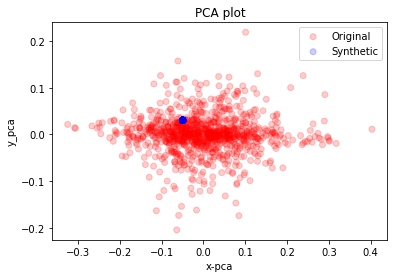

In [ ]:
PCA_Analysis (dataX, dataX_hat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.070423
[t-SNE] KL divergence after 300 iterations: 0.698437


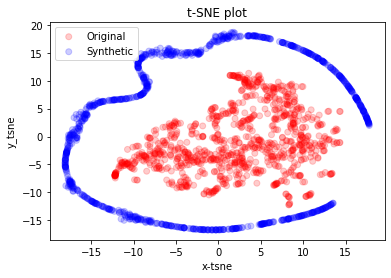

In [ ]:
tSNE_Analysis (dataX, dataX_hat)

In [ ]:
# Print Results
print('Discriminative Score - Mean: ' + str(np.round(np.mean(Discriminative_Score),4)) + ', Std: ' + str(np.round(np.std(Discriminative_Score),4)))
print('Predictive Score - Mean: ' + str(np.round(np.mean(Predictive_Score),4)) + ', Std: ' + str(np.round(np.std(Predictive_Score),4)))

Discriminative Score - Mean: 0.4999, Std: 0.0
Predictive Score - Mean: 0.1435, Std: 0.0


# DISEASE TRAJECTORY STATE PREDICTIONS

In [ ]:
def generate_doggo_trajectory(df, feats):

      # ['dog_id', 'hs_health_conditions_cancer', 'hs_general_health', 
    # 'hs_recent_hospitalization', 'db_excitement_level_before_walk', 
    # 'db_excitement_level_before_car_ride', 'db_aggression_level_approached_while_eating', 
    # 'db_aggression_level_on_leash_unknown_dog', 'db_fear_level_loud_noises', 
    # 'db_fear_level_unknown_human_touch', 'db_left_alone_barking_frequency', 
    # 'db_left_alone_restlessness_frequency', 'db_attention_seeking_follows_humans_frequency', 
    # 'db_attention_seeking_sits_close_to_humans_frequency', 'db_training_distraction_frequency', 
    # 'db_training_obeys_stay_command_frequency', 'db_barks_frequency', 
    # 'db_escapes_home_or_property_frequency', 'db_playful_frequency', 
    # 'db_urinates_in_home_frequency', 'dd_breed_pure_or_mixed', 'dd_age_years', 
    # 'dd_spayed_or_neutered', 'dd_insurance', 'dd_sex', 'dd_weight_range', 
    # 'de_daytime_sleep_avg_hours', 'de_nighttime_sleep_avg_hours', 'de_eats_feces', 
    # 'de_eats_grass_frequency', 'df_appetite', 'df_appetite_change_last_year', 
    # 'df_ever_malnourished', 'df_ever_overweight', 'df_ever_underweight', 
    # 'df_feedings_per_day', 'mp_dental_brushing_frequency', 'mp_flea_and_tick_treatment', 
    # 'mp_heartworm_preventative', 'hs_condition_type', 'hs_diagnosis_month', 
    # 'hs_diagnosis_year', 'hs_follow_up_ongoing', 'state', 'dd_combined_main_breed', 'free_fed', 'surg_hospital']

    # TAKE OUT: 'dog_id', 'hs_health_conditions_cancer', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year',
    
    drop_cols = ['hs_health_conditions_cancer', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year',]
    df.drop(drop_cols, axis=1)
   
    list_arr = []
    arry_list = np.array([])
    list_list = []
    list_feat = []
    cur_dog_id = df.iloc[0]['dog_id']
    
    # final_df['state'] = 0.0
    state_list = []
    list_state_list = []
    
    for index, row in df.iterrows(): 

        if cur_dog_id != row['dog_id']:
            arry_list = np.array(list_list)
            list_arr.append(arry_list)
            list_state_list.append(state_list)
        
            # reset various fields
            state_list = []
            arry_list = np.array([]) # shouldn't need this, but jic
            list_list = [] # reset the list of lists
            cur_dog_id = row['dog_id']

        # set up features list:
        # print('pre feats list_feat', list_feat)
        # print(feats)
        for feat in feats:
            # print(feat)
            list_feat.append(row[feat])
        # print(list_feat)
                         
        list_list.append(list_feat)
        state_list.append(row['state'])
        list_feat = [] # shouldn't need this, but jic
    
    # load final vars
    X_ = list_arr
    
    S_ = list_state_list
     
    return X_, S_ 

In [ ]:
## Data Loading
seq_length = 4

# generate the data
assm_df, assm_feat_list = doggo_data_loading(seq_length=seq_length) #  apply_seq_length=True, use_surg=False, 
feat_num = len(assm_feat_list)
# print(feat_num)
# print(feat_list) # should be 5 less than df columns ['dog_id', 'hs_health_conditions_cancer', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year']
print(assm_df.columns.values.tolist())

X_observations, true_states = generate_doggo_trajectory(assm_df[0:17000], feats=assm_feat_list)

feature size:  42
Joined SIZE:  (49425, 47)
['dog_id', 'hs_health_conditions_cancer', 'hs_general_health', 'hs_recent_hospitalization', 'db_excitement_level_before_walk', 'db_excitement_level_before_car_ride', 'db_aggression_level_approached_while_eating', 'db_aggression_level_on_leash_unknown_dog', 'db_fear_level_loud_noises', 'db_fear_level_unknown_human_touch', 'db_left_alone_barking_frequency', 'db_left_alone_restlessness_frequency', 'db_attention_seeking_follows_humans_frequency', 'db_attention_seeking_sits_close_to_humans_frequency', 'db_training_distraction_frequency', 'db_training_obeys_stay_command_frequency', 'db_barks_frequency', 'db_escapes_home_or_property_frequency', 'db_playful_frequency', 'db_urinates_in_home_frequency', 'dd_breed_pure_or_mixed', 'dd_age_years', 'dd_spayed_or_neutered', 'dd_insurance', 'dd_sex', 'dd_weight_range', 'de_daytime_sleep_avg_hours', 'de_nighttime_sleep_avg_hours', 'de_eats_feces', 'de_eats_grass_frequency', 'df_appetite', 'df_appetite_change_

In [ ]:
trajectory_index = 50

true_states[trajectory_index]

[0.0, 0.0, 1.0, 1.0, 1.0, 1.0]

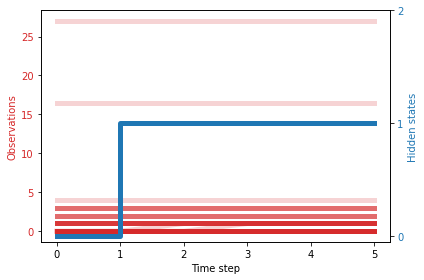

In [ ]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [ ]:
model = attentive_state_space_model(num_states=2,
                              maximum_seq_length=30, 
                              input_dim=feat_num, # 6, # started with: 6. tried 10, but broke, but that was original, adjust for how many features used in data
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=5, # 50,   # started with: 5
                              num_epochs=2, # 3,  # started with: 2
                              batch_size=10, # 100,  # started with: 10
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=5, # 100,  # started with: 5
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=5, # 100,  # started with: 5
                              num_out_layers=1)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [ ]:
model.fit(X_observations)

TensorFlow version : >= 1.0
---------------------------
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -6.913734e+01
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -6.814058e+01
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -6.844641e+01
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -6.396047e+01
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -6.884495e+01
Epoch 1 	----- 	Batch 0 	----- 	Log-Likelihood -7.091926e+01
Epoch 1 	----- 	Batch 1 	----- 	Log-Likelihood -6.421554e+01
Epoch 1 	----- 	Batch 2 	----- 	Log-Likelihood -6.430626e+01
Epoch 1 	----- 	Batch 3 	----- 	Log-Likelihood -6.331911e+01
Epoch 1 	----- 	Batch 4 	----- 	Log-Likelihood -6.819980e+01
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 comp

In [ ]:
model.initial_probabilities

array([0.83776887, 0.16223113])

In [ ]:
model.transition_matrix

array([[1., 0.],
       [0., 1.]])

In [ ]:
model.state_means.T 

array([[2.42961723e+00, 2.32930969e+00],
       [3.55574148e-02, 3.69671822e-02],
       [2.20058565e+00, 2.35496039e+00],
       [2.14006833e+00, 2.28366654e+00],
       [9.30767616e-02, 1.24481331e-01],
       [1.16133305e+00, 1.10071671e+00],
       [1.58697623e+00, 1.47302905e+00],
       [6.30342327e-01, 6.75971332e-01],
       [9.15777731e-01, 1.05130140e+00],
       [8.32322387e-01, 8.76650321e-01],
       [2.79488252e+00, 2.81026028e+00],
       [2.70996305e+00, 2.73066767e+00],
       [2.18936066e+00, 2.13843832e+00],
       [2.33089312e+00, 2.43606186e+00],
       [1.50198703e+00, 1.56205206e+00],
       [1.03932232e+00, 1.13315730e+00],
       [1.62406749e+00, 1.73519427e+00],
       [1.95077738e-01, 2.26706903e-01],
       [1.50721606e+00, 1.45680875e+00],
       [1.04913257e+01, 9.48233378e+00],
       [1.00000000e+00, 7.52168993e-01],
       [1.97029910e-01, 2.22557525e-01],
       [1.48929792e+00, 1.43794794e+00],
       [5.12633340e+00, 5.32629197e+00],
       [1.000000

In [ ]:
model.state_covars

array([[[ 1.05366471e+00,  2.30004330e-02, -1.75905235e-01, ...,
          3.44588915e-03,  6.47644526e-03,  2.89097819e-02],
        [ 2.30004330e-02,  3.42940850e-02,  4.88961705e-05, ...,
          8.56608922e-04,  8.38849974e-03,  1.89653837e-03],
        [-1.75905235e-01,  4.88961705e-05,  1.11510349e+00, ...,
          1.86291332e-02, -2.46675544e-03, -6.99674538e-03],
        ...,
        [ 3.44588915e-03,  8.56608922e-04,  1.86291332e-02, ...,
          8.63944841e-02, -1.22444576e-03,  9.74282487e-04],
        [ 6.47644526e-03,  8.38849974e-03, -2.46675544e-03, ...,
         -1.22444576e-03,  2.18409866e-01,  6.89976970e-03],
        [ 2.89097819e-02,  1.89653837e-03, -6.99674538e-03, ...,
          9.74282487e-04,  6.89976970e-03,  8.17368799e-02]],

       [[ 1.02131848e+00,  2.32846661e-02, -2.58347953e-01, ...,
          2.79731884e-03,  1.32338693e-02,  4.89887235e-02],
        [ 2.32846661e-02,  3.56016096e-02, -1.19902371e-02, ...,
          1.52992380e-03,  4.14468196e

In [ ]:
X_observations[3]

array([[ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  1.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.

In [ ]:
predict_idx = 0
state_inference, expected_observations, attention = model.predict([X_observations[predict_idx]])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./mlaimRNN_model


In [ ]:
np.argmax(state_inference[predict_idx], axis=1)

array([0, 0, 0, 0, 0])

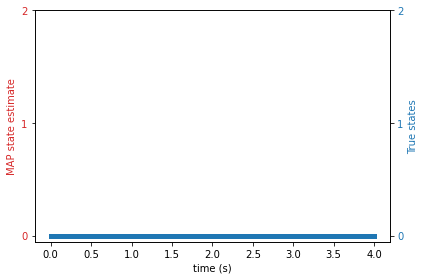

In [ ]:
fig, ax1 = plt.subplots()

trajectory_index = 0

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t, np.argmax(state_inference[trajectory_index], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

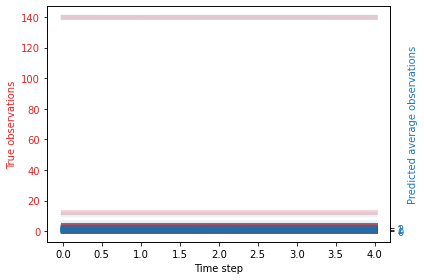

In [ ]:
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t, expected_observations[trajectory_index], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

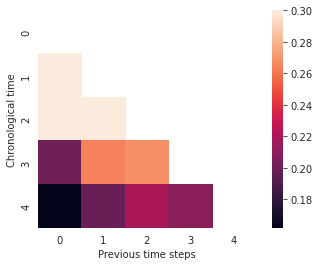

In [ ]:
# Visualize the attention weights over time
import seaborn as sns

Attention_weights = []

for w in range(len(attention[0])):
    
    Attention_weights.append(np.vstack((attention[0][w], np.zeros((len(attention[0][-1]) - len(attention[0][w]),1)))))


Attention_weights = np.array(Attention_weights).reshape((len(attention[0][-1]), len(attention[0][-1])))[:state_inference[0].shape[0], :state_inference[0].shape[0]]

mask = np.zeros_like(Attention_weights)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights, mask=mask, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

# TimeGANs Synthesized Data with ASSM Model

In [ ]:
# syn_df = pd.DataFrame(dataX, columns=assm_feat_list) # ,dtype=float
list_of_lists = []

for arr in dataX_hat: #dataX
    # print(arr)
    for outer_lst in arr:
        # print(outer_lst)
        # print(outer_lst.shape)
        list_of_lists.append(outer_lst)
        # for d in outer_lst:
        #     print(d)
        
# print(len(assm_feat_list))
# print(assm_feat_list)
syn_df = pd.DataFrame(list_of_lists) # , columns=assm_feat_list)

# print(syn_df.shape)

class NumAdv:
    def __iter__(self):
        self.a = int(1)
        return self
    
    def __next__(self):
        x = self.a
        self.a += 1
        if self.a % 2==0:
            fin = (x / 2)
        else:
            fin = ((x - 1) / 2)
        return fin * 2

def get_id(df):
    dog_id = ((next(myiter)) + 100000) # original dog ids max at 92582
    return dog_id

# add a non-consecutive id for every 2 rows
idclass = NumAdv()
myiter = iter(idclass)
syn_df['dog_id'] = syn_df.apply(get_id, axis = 1)

syn_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,dog_id
0,0.542304,0.283726,0.383563,0.135032,0.510374,0.438721,0.148218,0.323177,0.367583,0.145483,...,0.607366,0.420539,0.464274,0.115193,0.407514,0.163171,0.130450,0.127246,0.182826,100001.0
1,0.598852,0.173456,0.338794,0.037249,0.481781,0.369887,0.046853,0.241380,0.304126,0.051029,...,0.645703,0.365306,0.427481,0.034249,0.336159,0.058438,0.036720,0.037665,0.080609,100001.0
2,0.644148,0.129068,0.338851,0.018432,0.459986,0.339548,0.027366,0.224432,0.277273,0.032056,...,0.674190,0.355366,0.382615,0.019842,0.301541,0.031156,0.018684,0.021594,0.061269,100003.0
3,0.672838,0.106610,0.349791,0.012430,0.446291,0.326808,0.021674,0.224710,0.264790,0.025773,...,0.694983,0.354905,0.346938,0.015079,0.287445,0.021577,0.012847,0.016866,0.056663,100003.0
4,0.542306,0.283692,0.383538,0.134990,0.510368,0.438718,0.148176,0.323145,0.367563,0.145444,...,0.607380,0.420515,0.464274,0.115159,0.407496,0.163130,0.130410,0.127203,0.182776,100005.0


In [ ]:
def generate_doggo_trajectory_syn(df, feats):
    # print(assm_df.head(5))

      # ['dog_id', 'hs_health_conditions_cancer' (1), 'hs_general_health', 
    # 'hs_recent_hospitalization', 'db_excitement_level_before_walk', 
    # 'db_excitement_level_before_car_ride', 'db_aggression_level_approached_while_eating', 
    # 'db_aggression_level_on_leash_unknown_dog', 'db_fear_level_loud_noises', 
    # 'db_fear_level_unknown_human_touch', 'db_left_alone_barking_frequency', 
    # 'db_left_alone_restlessness_frequency', 'db_attention_seeking_follows_humans_frequency', 
    # 'db_attention_seeking_sits_close_to_humans_frequency', 'db_training_distraction_frequency', 
    # 'db_training_obeys_stay_command_frequency', 'db_barks_frequency', 
    # 'db_escapes_home_or_property_frequency', 'db_playful_frequency', 
    # 'db_urinates_in_home_frequency', 'dd_breed_pure_or_mixed', 'dd_age_years', 
    # 'dd_spayed_or_neutered', 'dd_insurance', 'dd_sex', 'dd_weight_range', 
    # 'de_daytime_sleep_avg_hours', 'de_nighttime_sleep_avg_hours', 'de_eats_feces', 
    # 'de_eats_grass_frequency', 'df_appetite', 'df_appetite_change_last_year', 
    # 'df_ever_malnourished', 'df_ever_overweight', 'df_ever_underweight', 
    # 'df_feedings_per_day', 'mp_dental_brushing_frequency', 'mp_flea_and_tick_treatment', 
    # 'mp_heartworm_preventative', 'hs_condition_type' (39), 'hs_diagnosis_month' (40), 
    # 'hs_diagnosis_year' (41), 'hs_follow_up_ongoing', 'state', 'dd_combined_main_breed', 'free_fed', 'surg_hospital']

    # TAKE OUT: 'hs_health_conditions_cancer' (1), 'hs_condition_type' (39), 'hs_diagnosis_month' (40), 'hs_diagnosis_year' (41)
    
    drop_cols = [1, 39, 40, 41]
    df.drop(drop_cols, axis=1)

    list_arr = []
    arry_list = np.array([])
    list_list = []
    list_feat = []
    cur_dog_id = df.iloc[0]['dog_id']
    
    # df['state'] = 0.0
    state_list = []
    list_state_list = []
    
    for index, row in df.iterrows(): 
        if cur_dog_id != row['dog_id']:
            # print('list_list: ', list_list)
            arry_list = np.array(list_list)
            # print('arry_list: ', arry_list)
            list_arr.append(arry_list)
            list_state_list.append(state_list)
        
            # reset various fields
            state_list = []
            arry_list = np.array([]) # shouldn't need this, but jic
            list_list = [] # reset the list of lists
            cur_dog_id = row['dog_id']

        # set up features list:
        # print('pre feats list_feat', list_feat)
        # print(feats)
        for feat in range(0,46):
            # print(feat)
            list_feat.append(row[feat])
        # # have to skip skin
        # for feat in range(40,46):
        #     # print(feat)
        #     list_feat.append(row[feat])
            
        # print('list_feat: ', list_feat)
        # print('list_feat size: ', len(list_feat))
        list_list.append(list_feat)
        state_list.append(row[46])
        list_feat = [] # shouldn't need this, but jic
    
    # load final vars
    X_ = list_arr
    S_ = list_state_list

    return X_, S_ 

In [ ]:
## Data Loading

# FYI - can't get entire DF to run through without ASSM collapsing.  Max on minimum params is 21,000, larger params 29,400
X_observations_syn, true_states_syn = generate_doggo_trajectory_syn(syn_df[0:17300], feats=assm_feat_list)

# TODO adjust 0:20000 to as high as possible
# keep adding categories!

# assm_df.head(10)
# X_observations[0:3]
# true_states[0:10]

# ## Data Loading
# seq_length = 4
# data_cats = [1]

# df, feat_num, feat_list = doggo_data_loading(seq_length=seq_length, data_cat=data_cats)

In [ ]:
trajectory_index_syn = 3

true_states_syn[trajectory_index_syn]

[0.061264753341674805, 0.05666077136993408]

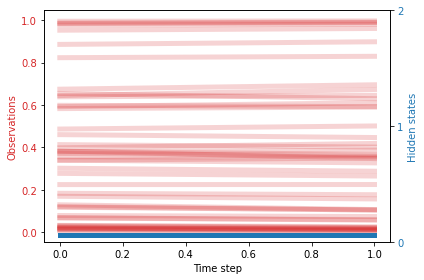

In [ ]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t_syn = list(range(len(true_states_syn[trajectory_index_syn])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t_syn, X_observations_syn[trajectory_index_syn], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t_syn, true_states_syn[trajectory_index_syn], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [ ]:
print(feat_num)
model_syn = attentive_state_space_model(num_states=2,
                              maximum_seq_length=30, 
                              input_dim=feat_num+4, # 6,  # started with: 6. tried 10, but broke, but that was original, adjust for how many features used in data
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=5, # 50,   # started with: 5
                              num_epochs=2, # 3,  # started with: 2
                              batch_size=10, # 100,  # started with: 10
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=5, # 100,  # started with: 5
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=5, # 100,  # started with: 5
                              num_out_layers=1)

42


In [ ]:
model_syn.fit(X_observations_syn)

TensorFlow version : >= 1.0
---------------------------
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -2.978446e+06
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -2.976817e+06
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -2.995313e+06
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -2.979632e+06
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -2.967548e+06
Epoch 1 	----- 	Batch 0 	----- 	Log-Likelihood -2.967422e+06
Epoch 1 	----- 	Batch 1 	----- 	Log-Likelihood -2.993348e+06
Epoch 1 	----- 	Batch 2 	----- 	Log-Likelihood -2.996089e+06
Epoch 1 	----- 	Batch 3 	----- 	Log-Likelihood -2.998756e+06
Epoch 1 	----- 	Batch 4 	----- 	Log-Likelihood -3.001272e+06
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: attentive_state_space/saved_model.pb


In [ ]:
model_syn.initial_probabilities

array([0.49994219, 0.50005781])

In [ ]:
model_syn.transition_matrix

array([[1., 0.],
       [1., 0.]])

In [ ]:
model_syn.state_means.T 

array([[0.63860908, 0.54230278],
       [0.13638126, 0.2837266 ],
       [0.34247893, 0.38356471],
       [0.02270496, 0.13503296],
       [0.46268764, 0.51037479],
       [0.34541589, 0.43872112],
       [0.03196577, 0.14822035],
       [0.23017536, 0.32317829],
       [0.28206558, 0.3675849 ],
       [0.03628739, 0.14548459],
       [0.08384806, 0.19799947],
       [0.12491688, 0.26289447],
       [0.65154199, 0.6335527 ],
       [0.63432521, 0.58167411],
       [0.58610974, 0.50956952],
       [0.59423412, 0.57010805],
       [0.17458353, 0.30176052],
       [0.1896266 , 0.29986554],
       [0.41448359, 0.44900906],
       [0.00855047, 0.07554286],
       [0.37514913, 0.42242753],
       [0.38520233, 0.44674372],
       [0.98370465, 0.8974694 ],
       [0.07176601, 0.19380004],
       [0.3816186 , 0.42983798],
       [0.58049238, 0.53468819],
       [0.97310864, 0.88202143],
       [0.98034421, 0.87759981],
       [0.99304698, 0.93360992],
       [0.87750815, 0.73312152],
       [0.

In [ ]:
model_syn.state_covars

array([[[ 9.28695069e-04, -8.44561179e-04,  1.25561233e-04, ...,
         -4.70908934e-04, -3.05644379e-04, -2.66961656e-04],
        [-8.44561179e-04,  7.72497083e-04, -1.09257718e-04, ...,
          4.32276248e-04,  2.80842471e-04,  2.45563768e-04],
        [ 1.25561233e-04, -1.09257718e-04,  2.77346416e-05, ...,
         -5.68584602e-05, -3.63782529e-05, -3.12631018e-05],
        ...,
        [-4.70908934e-04,  4.32276248e-04, -5.68584602e-05, ...,
          2.44895632e-04,  1.58672262e-04,  1.38951395e-04],
        [-3.05644379e-04,  2.80842471e-04, -3.63782529e-05, ...,
          1.58672262e-04,  1.04255941e-04,  9.04495690e-05],
        [-2.66961656e-04,  2.45563768e-04, -3.12631018e-05, ...,
          1.38951395e-04,  9.04495690e-05,  8.02576671e-05]],

       [[ 1.00001651e-06, -1.77236634e-10, -1.33856879e-10, ...,
         -2.18578247e-10, -2.15904836e-10, -2.34547345e-10],
        [-1.77236634e-10,  1.00192232e-06,  1.45185717e-09, ...,
          2.37045308e-09,  2.34129388e

In [ ]:
X_observations_syn[3]

array([[0.64415008, 0.12906113, 0.33884484, 0.01842961, 0.45998573,
        0.33955282, 0.02736264, 0.22443005, 0.27726832, 0.03205299,
        0.078527  , 0.11751476, 0.65418184, 0.63840139, 0.59203339,
        0.59814292, 0.16923729, 0.18330005, 0.41278309, 0.00657201,
        0.37121278, 0.38092485, 0.98652351, 0.06644017, 0.37789628,
        0.58274442, 0.97616196, 0.98403239, 0.99456531, 0.88539624,
        0.82277262, 0.01134044, 0.01252848, 0.39780101, 0.06917244,
        0.48624483, 0.1202437 , 0.95235288, 0.67419559, 0.35535797,
        0.38260803, 0.01984102, 0.30153388, 0.03115278, 0.01868203,
        0.02159178],
       [0.67283773, 0.1066058 , 0.34978613, 0.012429  , 0.4462921 ,
        0.32681358, 0.02167219, 0.22470972, 0.26478848, 0.02577195,
        0.07367587, 0.10496041, 0.62948036, 0.64496243, 0.6099745 ,
        0.59181607, 0.15668687, 0.17662328, 0.40124503, 0.00420538,
        0.3604216 , 0.36691928, 0.9900862 , 0.05914068, 0.38676304,
        0.59006751, 0.98039

In [ ]:
predict_idx_syn = 0
state_inference_syn, expected_observations_syn, attention_syn = model_syn.predict([X_observations_syn[predict_idx_syn]])

INFO:tensorflow:Restoring parameters from ./mlaimRNN_model


In [ ]:
np.argmax(state_inference_syn[predict_idx_syn], axis=1)

array([0, 0])

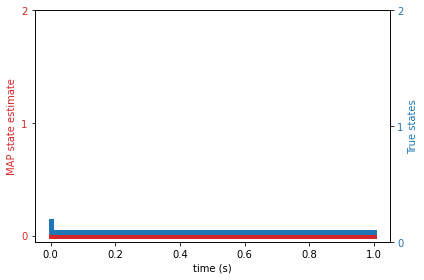

In [ ]:
fig, ax1 = plt.subplots()
trajectory_index_syn = 0
t_syn = list(range(len(true_states_syn[trajectory_index_syn])))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t_syn, np.argmax(state_inference_syn[trajectory_index_syn], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t_syn, true_states_syn[trajectory_index_syn], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

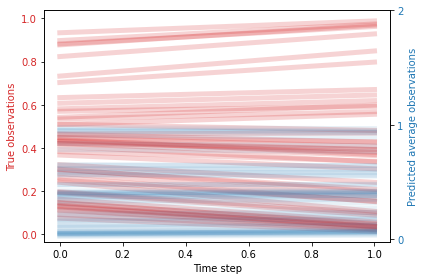

In [ ]:
fig, ax1 = plt.subplots()
t_syn = list(range(len(true_states_syn[trajectory_index_syn])))
color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t_syn, X_observations_syn[trajectory_index_syn], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t_syn, expected_observations_syn[trajectory_index_syn], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

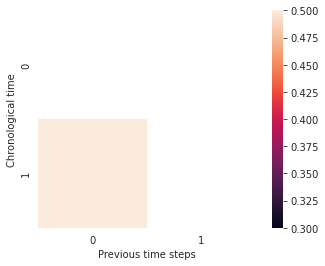

In [ ]:
# Visualize the attention weights over time
import seaborn as sns
Attention_weights_syn = []
for w in range(len(attention_syn[0])):
    Attention_weights_syn.append(np.vstack((attention_syn[0][w], np.zeros((len(attention_syn[0][-1]) - len(attention_syn[0][w]),1)))))
Attention_weights_syn = np.array(Attention_weights_syn).reshape((len(attention_syn[0][-1]), len(attention_syn[0][-1])))[:state_inference_syn[0].shape[0], :state_inference_syn[0].shape[0]]
mask_syn = np.zeros_like(Attention_weights_syn)
mask_syn[np.triu_indices_from(mask_syn)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights_syn, mask=mask_syn, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

# Using TimeGANs to Oversample Minority Data Class

In [24]:
# take original TimeGANs loaded data as usual, 
#   but then filter by 'hs_health_conditions_cancer'==1
#   before passing into TimeGANs 
print('current df size: ', gan_df.shape)
gan_df_min = gan_df[gan_df['hs_health_conditions_cancer'] == 1]
print('new df size: ', gan_df_min.shape) # should be about 85% smaller?

# so run original timeGANS data changer, but on smaller df
dataX_min = doggo_data_timeGANs(gan_df_min)

print('minority doggo dataset is ready')
# df.sample(28)
# df.head(28)
gan_df_min # .head(50)

# len(dataX_min)

current df size:  (49425, 47)
new df size:  (8172, 47)
dataframe shape pre:  (8172, 47)
dataframe shape post:  (8172, 42)
x: 8172
x2: 8172
x3: 8172
seq length: 4
dataX: 8168
8168
minority doggo dataset is ready


,dog_id,hs_health_conditions_cancer,hs_general_health,hs_recent_hospitalization,db_excitement_level_before_walk,db_excitement_level_before_car_ride,db_aggression_level_approached_while_eating,db_aggression_level_on_leash_unknown_dog,db_fear_level_loud_noises,db_fear_level_unknown_human_touch,...,mp_flea_and_tick_treatment,mp_heartworm_preventative,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_follow_up_ongoing,dd_combined_main_breed,free_fed,surg_hospital,state
133,152,1,3,0,3.0,4.0,0.0,1.0,0.0,0.0,...,0,1,16.0,8.0,2009.0,1,153.0,0,1.0,0
134,152,1,3,0,3.0,4.0,0.0,1.0,0.0,0.0,...,0,1,20.0,8.0,2010.0,1,153.0,0,3.0,1
135,152,1,3,0,3.0,4.0,0.0,1.0,0.0,0.0,...,0,1,3.0,5.0,2020.0,0,153.0,0,1.0,1
136,152,1,3,0,3.0,4.0,0.0,1.0,0.0,0.0,...,0,1,3.0,5.0,2020.0,1,153.0,0,1.0,1
302,307,1,4,0,2.0,3.0,0.0,1.0,1.0,0.0,...,0,1,3.0,1.0,2012.0,1,161.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73318,92418,1,3,0,3.0,3.0,1.0,4.0,3.0,0.0,...,1,1,16.0,11.0,2008.0,0,46.0,0,1.0,0
73319,92418,1,3,0,3.0,3.0,1.0,4.0,3.0,0.0,...,1,1,18.0,7.0,2009.0,0,46.0,0,1.0,0
73320,92418,1,3,0,3.0,3.0,1.0,4.0,3.0,0.0,...,1,1,20.0,12.0,2017.0,0,46.0,0,1.0,1
73321,92418,1,3,0,3.0,3.0,1.0,4.0,3.0,0.0,...,1,1,3.0,7.0,2019.0,0,46.0,0,1.0,1


In [14]:
## Main Parameters
# Experiments iterations
Iteration = 1 # 2 # started with: 1
Sub_Iteration = 2 # 3 # started with: 2

## Newtork Parameters
parameters_min = dict()

parameters_min['hidden_dim'] = len(dataX_min[0][0,:]) * 4
parameters_min['num_layers'] = 2 # 3 # started with: 2 (has to be at least 2!)
parameters_min['iterations'] = 10 # 10000 # started with: 1000, low as 10
parameters_min['batch_size'] = 2 # 128 # started with: 64, low as 2
parameters_min['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters_min['z_dim'] = len(dataX_min[0][0,:]) 

print('Minority class parameters are ' + str(parameters_min))

## Experiments
# Output Initialization
Discriminative_Score_min = list()
Predictive_Score_min = list()

Minority class parameters are {'hidden_dim': 168, 'num_layers': 2, 'iterations': 10, 'batch_size': 2, 'module_name': 'gru', 'z_dim': 42}


In [13]:
# Run TimeGANs model
print('Start iterations') 
    
# Each Iteration
for it in range(Iteration):

    # Synthetic Data Generation
    dataX_hat_min = timegan(dataX_min, parameters_min)   
      
    print('Finish Synthetic Data Generation')

    ## Performance Metrics
    
    # 1. Discriminative Score
    Acc_min = list()
    for tt in range(Sub_Iteration):
        Temp_Disc_min = discriminative_score_metrics(dataX_min, dataX_hat_min)
        Acc_min.append(Temp_Disc_min)
    
    Discriminative_Score_min.append(np.mean(Acc_min))
    
    # 2. Predictive Performance
    MAE_All_min = list()
    for tt in range(Sub_Iteration):
        MAE_All_min.append(predictive_score_metrics(dataX_min, dataX_hat_min))
        
    Predictive_Score_min.append(np.mean(MAE_All_min))    
    
print('Finish TimeGAN iterations')

Start iterations
Start Embedding Network Training
step: 0, e_loss: 0.4056
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.1051
Finish Training with Supervised Loss Only
Start Joint Training
step: 0, d_loss: 2.1653, g_loss_u: 0.6233, g_loss_s: 0.0284, g_loss_v: 0.2941, e_loss_t0: 0.3093
Finish Joint Training
Finish Synthetic Data Generation
Finish TimeGAN iterations


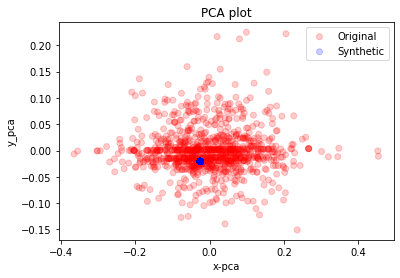

In [ ]:
PCA_Analysis(dataX_min, dataX_hat_min)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.850800
[t-SNE] KL divergence after 300 iterations: 0.718150


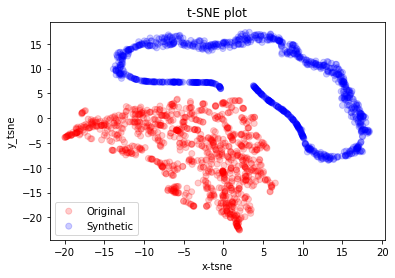

In [ ]:
tSNE_Analysis(dataX_min, dataX_hat_min)

In [ ]:
# Print Results
print('Minority class discriminative Score - Mean: ' + str(np.round(np.mean(Discriminative_Score_min),4)) + ', Std: ' + str(np.round(np.std(Discriminative_Score_min),4)))
print('Minority class  predictive Score - Mean: ' + str(np.round(np.mean(Predictive_Score_min),4)) + ', Std: ' + str(np.round(np.std(Predictive_Score_min),4)))

Minority class discriminative Score - Mean: 0.4994, Std: 0.0
Minority class  predictive Score - Mean: 0.4999, Std: 0.0


In [ ]:
print('new dogs: ', len(dataX_hat_min))
print('meet scruffy: ', dataX_hat_min[0])

new dogs:  8168
meet scruffy:  [[0.38521808 0.11850038 0.48930776 0.4541914  0.1470738  0.33505768
  0.4210059  0.15886462 0.26468536 0.24067584 0.6341559  0.61805934
  0.5911843  0.49612084 0.41388544 0.3277014  0.42713585 0.15872234
  0.5405357  0.52047026 0.80742383 0.34004182 0.49706095 0.43186152
  0.8196608  0.8961098  0.85511756 0.6349516  0.6567665  0.21725538
  0.17908588 0.37437332 0.27336133 0.5521649  0.2667537  0.7550199
  0.66057515 0.4453719  0.19943711 0.18963274 0.11459073 0.5579763 ]
 [0.33051014 0.02799025 0.4835894  0.44125423 0.04621994 0.2626246
  0.36230618 0.04731208 0.14187232 0.11985421 0.7244417  0.7066565
  0.6280207  0.50119877 0.3482214  0.23773268 0.39150155 0.04620531
  0.57149076 0.5354128  0.9341757  0.23094839 0.48186013 0.39388654
  0.9342052  0.9787775  0.9609544  0.7225625  0.7361238  0.08354202
  0.06081828 0.3130436  0.14149988 0.60777354 0.14670178 0.88363373
  0.7526908  0.39075774 0.07106861 0.06444225 0.0231851  0.54195917]
 [0.31762627 0.014

In [ ]:
seq_length = 4

# generate the data
# df, feat_num, feat_list = doggo_data_loading(seq_length=seq_length, data_cat=data_cats) # [1,2,3,4,5,6,7,8,9,10,11,12,13] # [1,10,14]
# final_df, feat_num, feat_list = doggo_data_loading(apply_seq_length=False, use_surg=False, data_cat=data_cats)
orig_df, orig_feat_list = doggo_data_loading(seq_length=seq_length, apply_seq_length=True) #  apply_seq_length=True, use_surg=False, 
orig_feat_num = len(orig_feat_list)
print(orig_feat_num, ' : ', orig_feat_list)

print(orig_df.shape)
orig_df.head(10)

feature size:  42
Joined SIZE:  (49425, 47)
42  :  ['hs_general_health', 'hs_recent_hospitalization', 'db_excitement_level_before_walk', 'db_excitement_level_before_car_ride', 'db_aggression_level_approached_while_eating', 'db_aggression_level_on_leash_unknown_dog', 'db_fear_level_loud_noises', 'db_fear_level_unknown_human_touch', 'db_left_alone_barking_frequency', 'db_left_alone_restlessness_frequency', 'db_attention_seeking_follows_humans_frequency', 'db_attention_seeking_sits_close_to_humans_frequency', 'db_training_distraction_frequency', 'db_training_obeys_stay_command_frequency', 'db_barks_frequency', 'db_escapes_home_or_property_frequency', 'db_playful_frequency', 'db_urinates_in_home_frequency', 'dd_breed_pure_or_mixed', 'dd_age_years', 'dd_spayed_or_neutered', 'dd_insurance', 'dd_sex', 'dd_weight_range', 'de_daytime_sleep_avg_hours', 'de_nighttime_sleep_avg_hours', 'de_eats_feces', 'de_eats_grass_frequency', 'df_appetite', 'df_appetite_change_last_year', 'df_ever_malnourished'

,dog_id,hs_health_conditions_cancer,hs_general_health,hs_recent_hospitalization,db_excitement_level_before_walk,db_excitement_level_before_car_ride,db_aggression_level_approached_while_eating,db_aggression_level_on_leash_unknown_dog,db_fear_level_loud_noises,db_fear_level_unknown_human_touch,...,mp_flea_and_tick_treatment,mp_heartworm_preventative,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_follow_up_ongoing,dd_combined_main_breed,free_fed,surg_hospital,state
4,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,3.0,1.0,2013.0,0,140.0,0,1.0,0
5,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,7.0,1.0,2013.0,1,140.0,0,1.0,0
6,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,18.0,9.0,2014.0,0,140.0,0,3.0,0
7,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,17.0,9.0,2019.0,0,140.0,0,1.0,0
8,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,4.0,8.0,2020.0,1,140.0,0,1.0,0
15,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,4.0,8.0,2010.0,0,243.0,0,1.0,0
16,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,3.0,2.0,2013.0,0,243.0,0,1.0,0
17,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,18.0,4.0,2013.0,0,243.0,0,1.0,0
18,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,16.0,3.0,2014.0,1,243.0,0,1.0,0
19,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,18.0,1.0,2015.0,0,243.0,0,1.0,0


In [ ]:
# combine new datapoints with existing dataset
def generate_doggo_trajectory_comb(orig_df, sync_data, feats):
    # print(assm_df.head(5))
    
    # syn_data is the dataX_hat output from the TimeGANs
    list_of_lists = []
    for arr in sync_data:
        # print(arr)
        for outer_lst in arr:
            # print(outer_lst)
            # print(outer_lst.shape)
            list_of_lists.append(outer_lst)
        
    sync_df = pd.DataFrame(list_of_lists)

    idclass = NumAdv()
    myiter = iter(idclass)
    sync_df['dog_id'] = sync_df.apply(get_id, axis = 1)
    print('sync_df size: ', sync_df.shape)

    # reduce the orig df columns, these fields not in the TimeGANs synth data:
    drop_cols = ['hs_health_conditions_cancer', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year'] #'dog_id' added to it above
    orig_df = orig_df.drop(drop_cols, axis=1)
    print('orig_df size: ', orig_df.shape)

    # move dog_id to front of columns to align with orig_df
    cols = list(sync_df)
    cols.insert(0, cols.pop(cols.index('dog_id')))
    sync_df = sync_df.loc[:, cols]

    # assign col names to sync data
    sync_df.columns = orig_df.columns

    # join the 2 dataframes
    comb_df = pd.concat([orig_df, sync_df])
    print('combined df size: ', comb_df.shape)
    
    list_arr = []
    arry_list = np.array([])
    list_list = []
    list_feat = []
    cur_dog_id = comb_df.iloc[0]['dog_id']
    
    # comb_df['state'] = 0.0
    state_list = []
    list_state_list = []
    
    for index, row in comb_df.iterrows(): 
        # set up state lists - 'hs_health_conditions_?????'
        # start with just skin - 'hs_health_conditions_skin', 1 YES, 2 NO
        # set up state lists
        # if row['hs_health_conditions_skin'] <= 0.5: # 'hs_health_conditions_skin'
        #     row['state'] = 1
        # elif row['hs_health_conditions_skin']  > 0.5: # 'hs_health_conditions_skin'
        #     row['state'] = 0
        
        if cur_dog_id != row['dog_id']:
            # print('list_list: ', list_list)
            arry_list = np.array(list_list)
            # print('arry_list: ', arry_list)
            list_arr.append(arry_list)
            list_state_list.append(state_list)
        
            # reset various fields
            state_list = []
            arry_list = np.array([]) # shouldn't need this, but jic
            list_list = [] # reset the list of lists
            cur_dog_id = row['dog_id']

        # set up features list:
        # hard code this for now, then go back and iterate it:
        # [‘hs_general_health','hs_recent_hospitalization']
        # [‘hs_follow_up_ongoing',‘hs_required_surgery_or_hospitalization’]
        # ['hs_health_conditions_skin','hs_health_conditions_eye','hs_health_conditions_cancer']
        
#         list_feat = [row['dis_skin'],row['dis_oral'], row['dis_trau'], row['dis_infe'], row['dis_bone'], row['dis_eyes']]
        # list_feat = [row['hs_general_health'],row['hs_recent_hospitalization'], row['hs_follow_up_ongoing'], row['hs_required_surgery_or_hospitalization'], row['hs_health_conditions_eye'], row['hs_health_conditions_cancer']]
        # print('pre feats list_feat', list_feat)
        # print(feats)
        for feat in feats:
            # print(feat)
            list_feat.append(row[feat])
        # print('list_feat: ', list_feat)
        # print('list_feat size: ', len(list_feat))
        list_list.append(list_feat)
        state_list.append(row['state'])
        list_feat = [] # shouldn't need this, but jic
    
    # if predict=='skin':
    #     drop_cols = ['hs_health_conditions_skin']
    #     df.drop(drop_cols, axis=1)
    # elif predict=='eye':
    #     drop_cols = ['hs_health_conditions_eye']
    #     df.drop(drop_cols, axis=1)            
    # elif predict=='cancer':
    #     drop_cols = ['hs_health_conditions_cancer']
    #     df.drop(drop_cols, axis=1)
    
    # load final vars
    X_ = list_arr
    # arrX = np.array(X_)
    # print('x shape: ', arrX.shape)
    
    S_ = list_state_list
    # arrS = np.array(S_)
    # print('x shape: ', arrS.shape)
    
#     print(arrX[0:20])
#     print(arrS[0:20])
    
    return X_, S_ 

In [ ]:
# FYI - can't get entire DF to run through without ASSM collapsing.  Max on minimum params is 21,000, larger params 29,400
# undersample the majority case. keep all minority case:
# TODO come back to this!

# combine and form data for model
X_observations_comb, true_states_comb = generate_doggo_trajectory_comb(orig_df[0:17000], dataX_hat_min, feats=assm_feat_list)

# TODO adjust 0:20000 to as high as possible
# keep adding categories!

# assm_df.head(20)
# X_observations[0:3]
# true_states[0:10]

# ## Data Loading
# seq_length = 4
# data_cats = [1]

# df, feat_num, feat_list = doggo_data_loading(seq_length=seq_length, data_cat=data_cats)

sync_df size:  (32672, 43)
orig_df size:  (17000, 43)
combined df size:  (49672, 43)


In [ ]:
trajectory_index_comb = 3

true_states_comb[trajectory_index_comb]

[0.0, 0.0, 0.0, 0.0, 0.0]

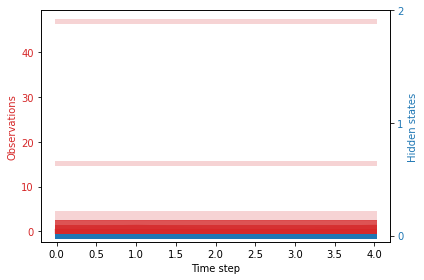

In [ ]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t_comb = list(range(len(true_states_comb[trajectory_index_comb])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t_comb, X_observations_comb[trajectory_index_comb], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t_comb, true_states_comb[trajectory_index_comb], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [ ]:
dims = orig_feat_num
print(dims)
model_comb = attentive_state_space_model(num_states=2,
                              maximum_seq_length=30, 
                              input_dim=dims, # 6,  # started with: 6. tried 10, but broke, but that was original, adjust for how many features used in data
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=5, # 50,   # started with: 5
                              num_epochs=2, # 3,  # started with: 2
                              batch_size=10, # 100,  # started with: 10
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=5, # 100,  # started with: 5
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=5, # 100,  # started with: 5
                              num_out_layers=1)

42


In [ ]:
model_comb.fit(X_observations_comb)

TensorFlow version : >= 1.0
---------------------------
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -2.071985e+06
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -1.280159e+06
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -7.956589e+05
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -1.874803e+06
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -1.028525e+06
Epoch 1 	----- 	Batch 0 	----- 	Log-Likelihood -1.479328e+06
Epoch 1 	----- 	Batch 1 	----- 	Log-Likelihood -1.133441e+06
Epoch 1 	----- 	Batch 2 	----- 	Log-Likelihood -1.247385e+06
Epoch 1 	----- 	Batch 3 	----- 	Log-Likelihood -8.840560e+05
Epoch 1 	----- 	Batch 4 	----- 	Log-Likelihood -1.557775e+06
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: attentive_state_space/saved_model.pb


In [ ]:
model_comb.initial_probabilities

array([0.85617695, 0.14382305])

In [ ]:
model_comb.transition_matrix

array([[1., 0.],
       [0., 1.]])

In [ ]:
model_comb.state_means.T 

array([[3.37284412e-01, 2.41382353e+00],
       [4.28347602e-02, 3.57647059e-02],
       [4.80673346e-01, 2.22494118e+00],
       [4.38423375e-01, 2.16276471e+00],
       [5.97483770e-02, 9.79411765e-02],
       [2.73341968e-01, 1.15217647e+00],
       [3.68385517e-01, 1.56970588e+00],
       [6.25749817e-02, 6.37235294e-01],
       [1.53666054e-01, 9.36588235e-01],
       [1.29858789e-01, 8.38941176e-01],
       [7.28874268e-01, 2.79735294e+00],
       [7.13446937e-01, 2.71329412e+00],
       [6.11645611e-01, 2.18100000e+00],
       [5.02415814e-01, 2.34752941e+00],
       [3.46162193e-01, 1.51152941e+00],
       [2.46194525e-01, 1.05358824e+00],
       [4.05455094e-01, 1.64152941e+00],
       [6.12259536e-02, 1.99941176e-01],
       [5.79424245e-01, 1.49917647e+00],
       [5.43853439e-01, 1.03346324e+01],
       [9.21808010e-01, 9.61352941e-01],
       [2.29011167e-01, 2.00941176e-01],
       [4.80008728e-01, 1.48147059e+00],
       [4.06423448e-01, 5.15817647e+00],
       [9.227049

In [ ]:
model_comb.state_covars

array([[[ 7.99089230e-04,  1.24567441e-03,  1.59748435e-04, ...,
          1.86167616e-03,  1.26073597e-03,  7.89792338e-04],
        [ 1.24567441e-03,  1.95153823e-03,  2.43825634e-04, ...,
          2.90339945e-03,  1.97388816e-03,  1.18982649e-03],
        [ 1.59748435e-04,  2.43825634e-04,  4.60653092e-05, ...,
          3.80489996e-04,  2.47065258e-04,  2.30544395e-04],
        ...,
        [ 1.86167616e-03,  2.90339945e-03,  3.80489996e-04, ...,
          4.34861303e-03,  2.93865233e-03,  1.88275317e-03],
        [ 1.26073597e-03,  1.97388816e-03,  2.47065258e-04, ...,
          2.93865233e-03,  1.99852723e-03,  1.20617641e-03],
        [ 7.89792338e-04,  1.18982649e-03,  2.30544395e-04, ...,
          1.88275317e-03,  1.20617641e-03,  1.22255321e-03]],

       [[ 1.04963344e+00,  2.30232526e-02, -1.90850657e-01, ...,
          3.27901384e-03,  7.57790657e-03,  3.21534948e-02],
        [ 2.30232526e-02,  3.44865917e-02, -1.80966090e-03, ...,
          9.63626298e-04,  7.71775779e

In [ ]:
X_observations_comb[3]

array([[ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  1.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.

In [ ]:
predict_idx_comb = 0
state_inference_comb, expected_observations_comb, attention_comb = model_comb.predict([X_observations_comb[predict_idx_comb]])

INFO:tensorflow:Restoring parameters from ./mlaimRNN_model


In [ ]:
np.argmax(state_inference_comb[predict_idx_comb], axis=1)

array([0, 0, 0, 0, 0])

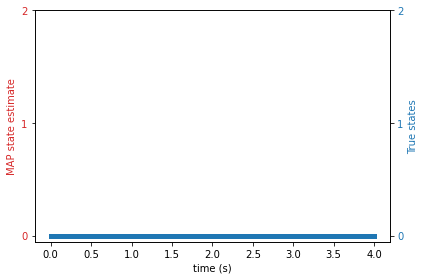

In [ ]:
fig, ax1 = plt.subplots()
trajectory_index_comb = 0
t_comb = list(range(len(true_states_comb[trajectory_index_comb])))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t_comb, np.argmax(state_inference_comb[trajectory_index_comb], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t_comb, true_states_comb[trajectory_index_comb], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

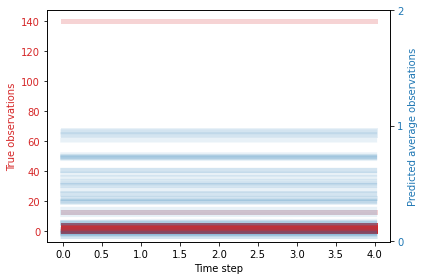

In [ ]:
fig, ax1 = plt.subplots()
t_comb = list(range(len(true_states_comb[trajectory_index_comb])))
color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t_comb, X_observations_comb[trajectory_index_comb], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t_comb, expected_observations_comb[trajectory_index_comb], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

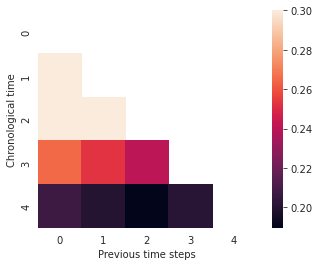

In [ ]:
# Visualize the attention weights over time
import seaborn as sns
Attention_weights_comb = []
for w in range(len(attention_comb[0])):
    Attention_weights_comb.append(np.vstack((attention_comb[0][w], np.zeros((len(attention_comb[0][-1]) - len(attention_comb[0][w]),1)))))
Attention_weights_comb = np.array(Attention_weights_comb).reshape((len(attention_comb[0][-1]), len(attention_comb[0][-1])))[:state_inference_comb[0].shape[0], :state_inference_comb[0].shape[0]]
mask_comb = np.zeros_like(Attention_weights_comb)
mask_comb[np.triu_indices_from(mask_comb)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights_comb, mask=mask_comb, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')